In [3]:
import warnings
import gdown
import pandas as pd
import numpy as np
import seaborn as snsb
from copy import deepcopy

warnings.filterwarnings("ignore")

In [ ]:
pip install -r /content/requirements.txt


In [ ]:
pip install etna


In [4]:
from etna.analysis import (
    cross_corr_plot,
    distribution_plot,
    acf_plot,
    plot_correlation_matrix,
)

from etna.transforms import LagTransform
from etna.datasets import TSDataset
from etna.analysis import plot_trend
from etna.transforms import LinearTrendTransform
from etna.analysis import plot_imputation
from etna.analysis import plot_periodogram, stl_plot, seasonal_plot
from etna.analysis.outliers import get_anomalies_median, get_anomalies_density
from etna.analysis import plot_anomalies
from etna.transforms import DensityOutliersTransform, TimeSeriesImputerTransform

Чуть-чуть про данные

In [24]:
bank_luquidity = pd.read_csv('/content/bank_luquidity.csv')
credits_firms =  pd.read_csv('/content/credits_firms.csv')
credits_people =  pd.read_csv('/content/credits_people.csv')
deposits_people =  pd.read_csv('/content/deposits_people.csv')
deposits_firms =  pd.read_csv('/content/deposits_firms.csv')
df_key_rate =  pd.read_csv('/content/df_key_rate.csv')
max_deposit_rate =  pd.read_csv('/content/max_deposit_rate.csv')
overdue_credits_people =  pd.read_csv('/content/overdue_credits_people.csv')
bank_luquidity.head(5)

bank_luquidity['month_start']  = pd.offsets.MonthBegin() +  pd.to_datetime(bank_luquidity['date'], format='%d.%m.%Y') -  pd.offsets.DateOffset(months= 1)
bank_luquidity = bank_luquidity.groupby('month_start').agg({'value': 'mean'})
bank_luquidity.reset_index(inplace=True)
bank_luquidity["date"] = pd.to_datetime(bank_luquidity['month_start'], format='%Y-%m-%d').dt.strftime('%d.%m.%Y')
bank_luquidity.drop(columns=['month_start'], inplace=True)

# усредняем значения по месяцу

df_key_rate['month_start']  = pd.offsets.MonthBegin() +  pd.to_datetime(df_key_rate['date'], format='%d.%m.%Y') -  pd.offsets.DateOffset(months= 1)
df_key_rate = df_key_rate.groupby('month_start').agg({'rate': 'mean'})

ts = ['bank_luquidity', 'credits_firms', 'credits_people',  'deposits_people', 'max_deposit_rate', 'overdue_credits_people']
ts = pd.DataFrame(ts, columns= ['segment'])
credits_firms["segment"] = 'credits_firms'
bank_luquidity["segment"] = 'bank_luquidity'
credits_people["segment"] = 'credits_people'
deposits_firms["segment"] = 'deposits_firms'
deposits_people["segment"] = 'deposits_people'
max_deposit_rate["segment"] = 'max_deposit_rate'
overdue_credits_people["segment"] = 'overdue_credits_people'


series = pd.concat([credits_firms,bank_luquidity])
series = pd.concat([series,credits_people])
series = pd.concat([series,deposits_people])
series = pd.concat([series,max_deposit_rate])
series = pd.concat([series,overdue_credits_people])

series["timestamp"] = pd.to_datetime(series['date'], format='%d.%m.%Y')
series["target"] = series["value"]

series.drop(columns=['date', 'value'], inplace=True)

series = series[series['timestamp'] >= '2019-02-01']
series = series[series['timestamp'] <= '2022-12-31']
series['timestamp'] = pd.offsets.MonthEnd() + series['timestamp']
series = series[['timestamp', 'target', 'segment']]

df_key_rate.reset_index(inplace=True)
df_key_rate["timestamp"] = df_key_rate.month_start
df_key_rate.drop(columns=['month_start'], inplace=True)
df_key_rate['timestamp'] = pd.offsets.MonthEnd() + df_key_rate['timestamp']
df_key_rate['_tempkey'] = 1
ts['_tempkey'] = 1

df_key_rate = df_key_rate.merge(ts, on='_tempkey').drop('_tempkey', axis=1)
df_key_rate['regressor_0'] = df_key_rate['rate']
df_key_rate.drop(columns=['rate'], inplace=True)
df_key_rate = df_key_rate[df_key_rate['timestamp'] >= '2019-02-01']
df_key_rate = df_key_rate[df_key_rate['timestamp'] <= '2022-12-31']

df_key_rate.head()

,timestamp,segment,regressor_0
390,2019-02-28,bank_luquidity,7.75
391,2019-02-28,credits_firms,7.75
392,2019-02-28,credits_people,7.75
393,2019-02-28,deposits_people,7.75
394,2019-02-28,max_deposit_rate,7.75


In [25]:
series.groupby('segment').agg({'timestamp': 'max'})


,timestamp
segment,
bank_luquidity,2022-12-31
credits_firms,2022-12-31
credits_people,2022-12-31
deposits_people,2022-12-31
max_deposit_rate,2022-12-31
overdue_credits_people,2022-12-31


###Теперь превратим все в датасеты для библиотеки

In [ ]:
series_ds = TSDataset.to_dataset(series)
ts_plots = TSDataset(series_ds, freq="M")
ts_plots.info()

<class 'etna.datasets.TSDataset'>
num_segments: 6
num_exogs: 0
num_regressors: 0
num_known_future: 0
freq: M
                       start_timestamp end_timestamp  length  num_missing
segments                                                                 
bank_luquidity              2019-02-28    2022-12-31      47            0
credits_firms               2019-02-28    2022-12-31      47            0
credits_people              2019-02-28    2022-12-31      47            0
deposits_people             2019-02-28    2022-12-31      47            0
max_deposit_rate            2019-02-28    2022-12-31      47            0
overdue_credits_people      2019-02-28    2022-12-31      47            0


Распределения

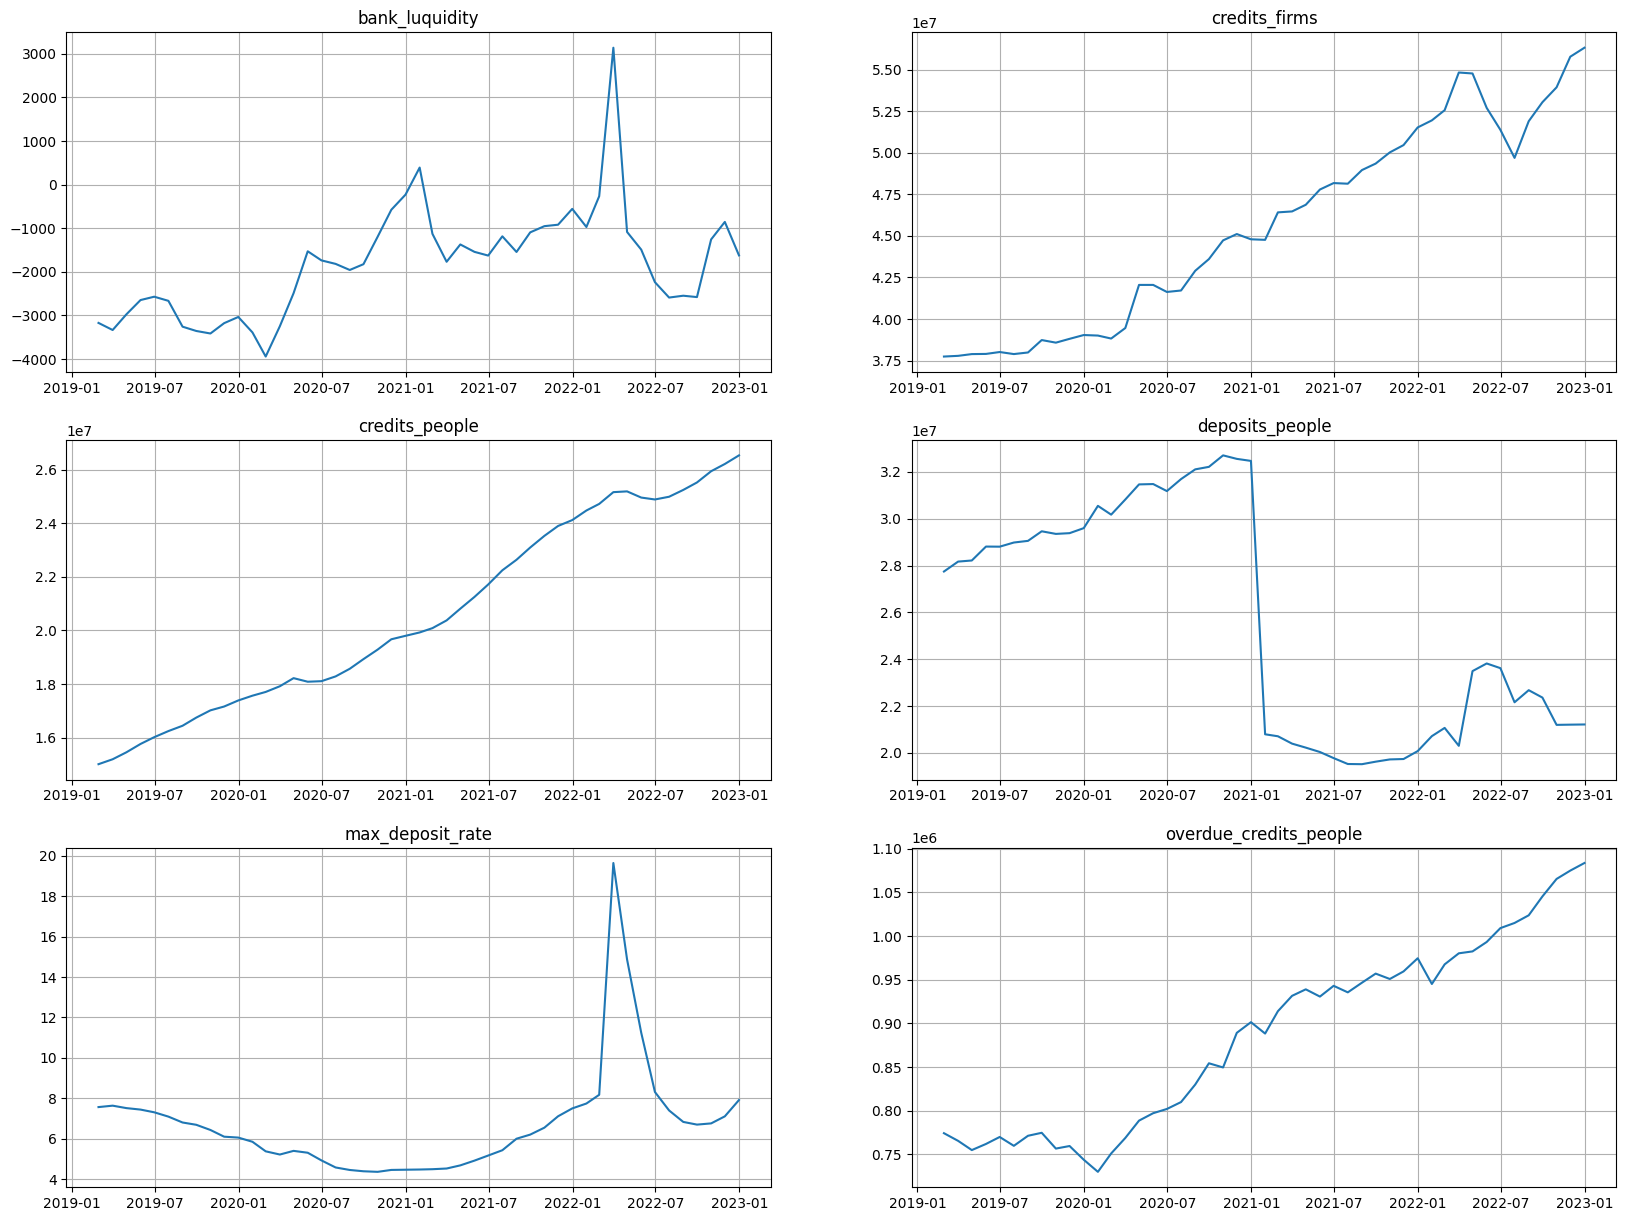

In [ ]:
ts_plots.plot()


ACF

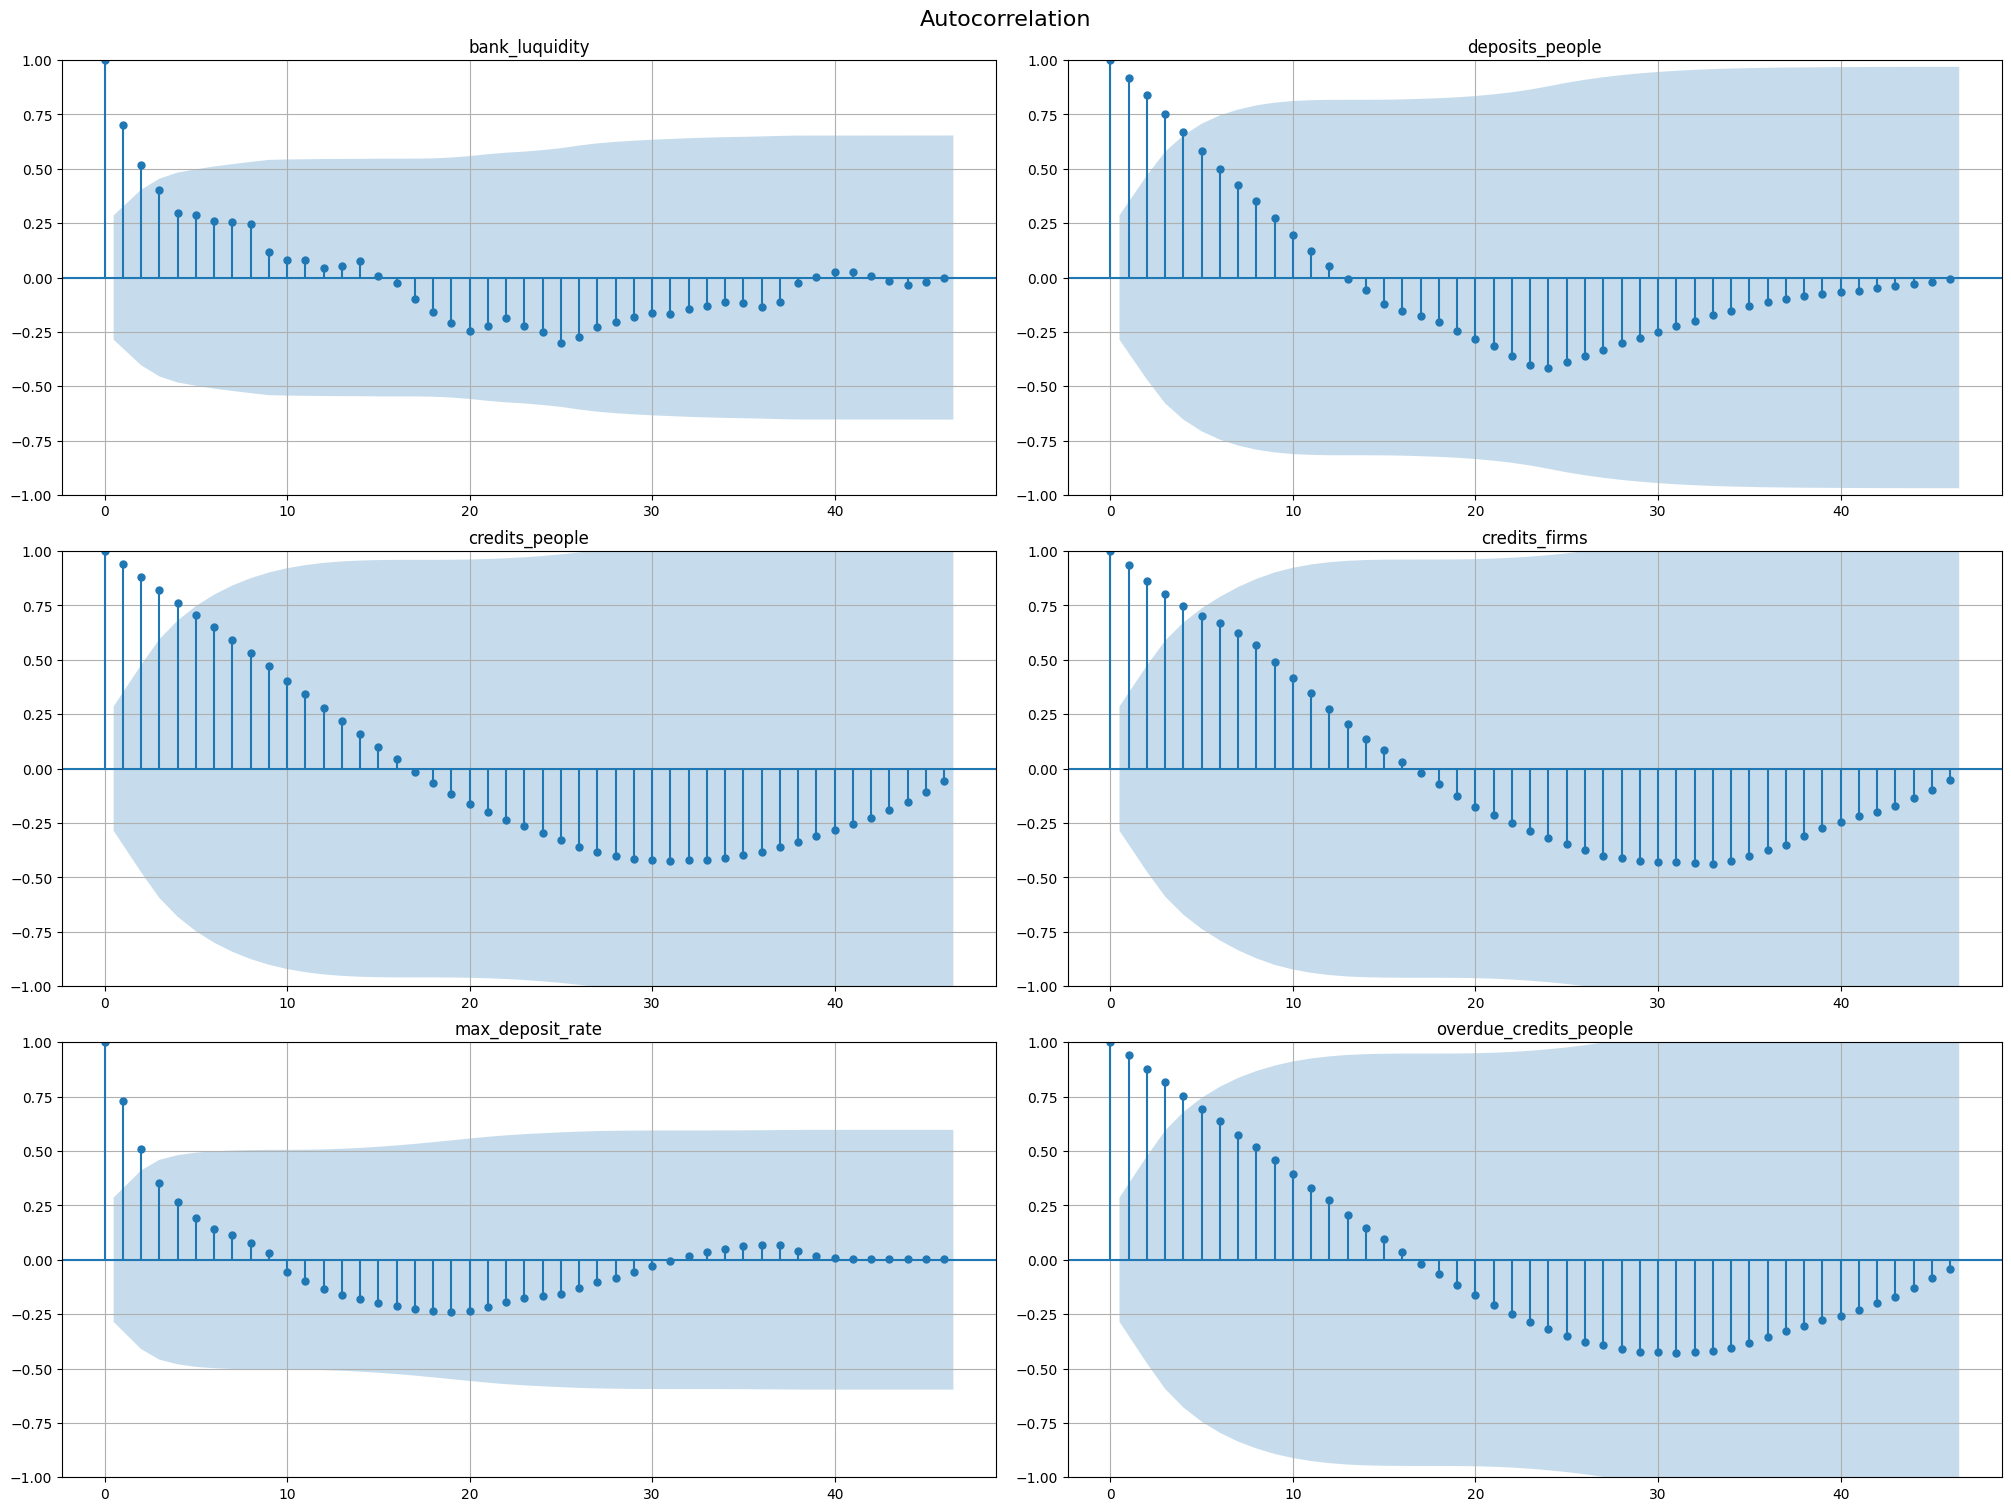

In [ ]:
acf_plot(ts_plots, lags=46)

Линейный тренд

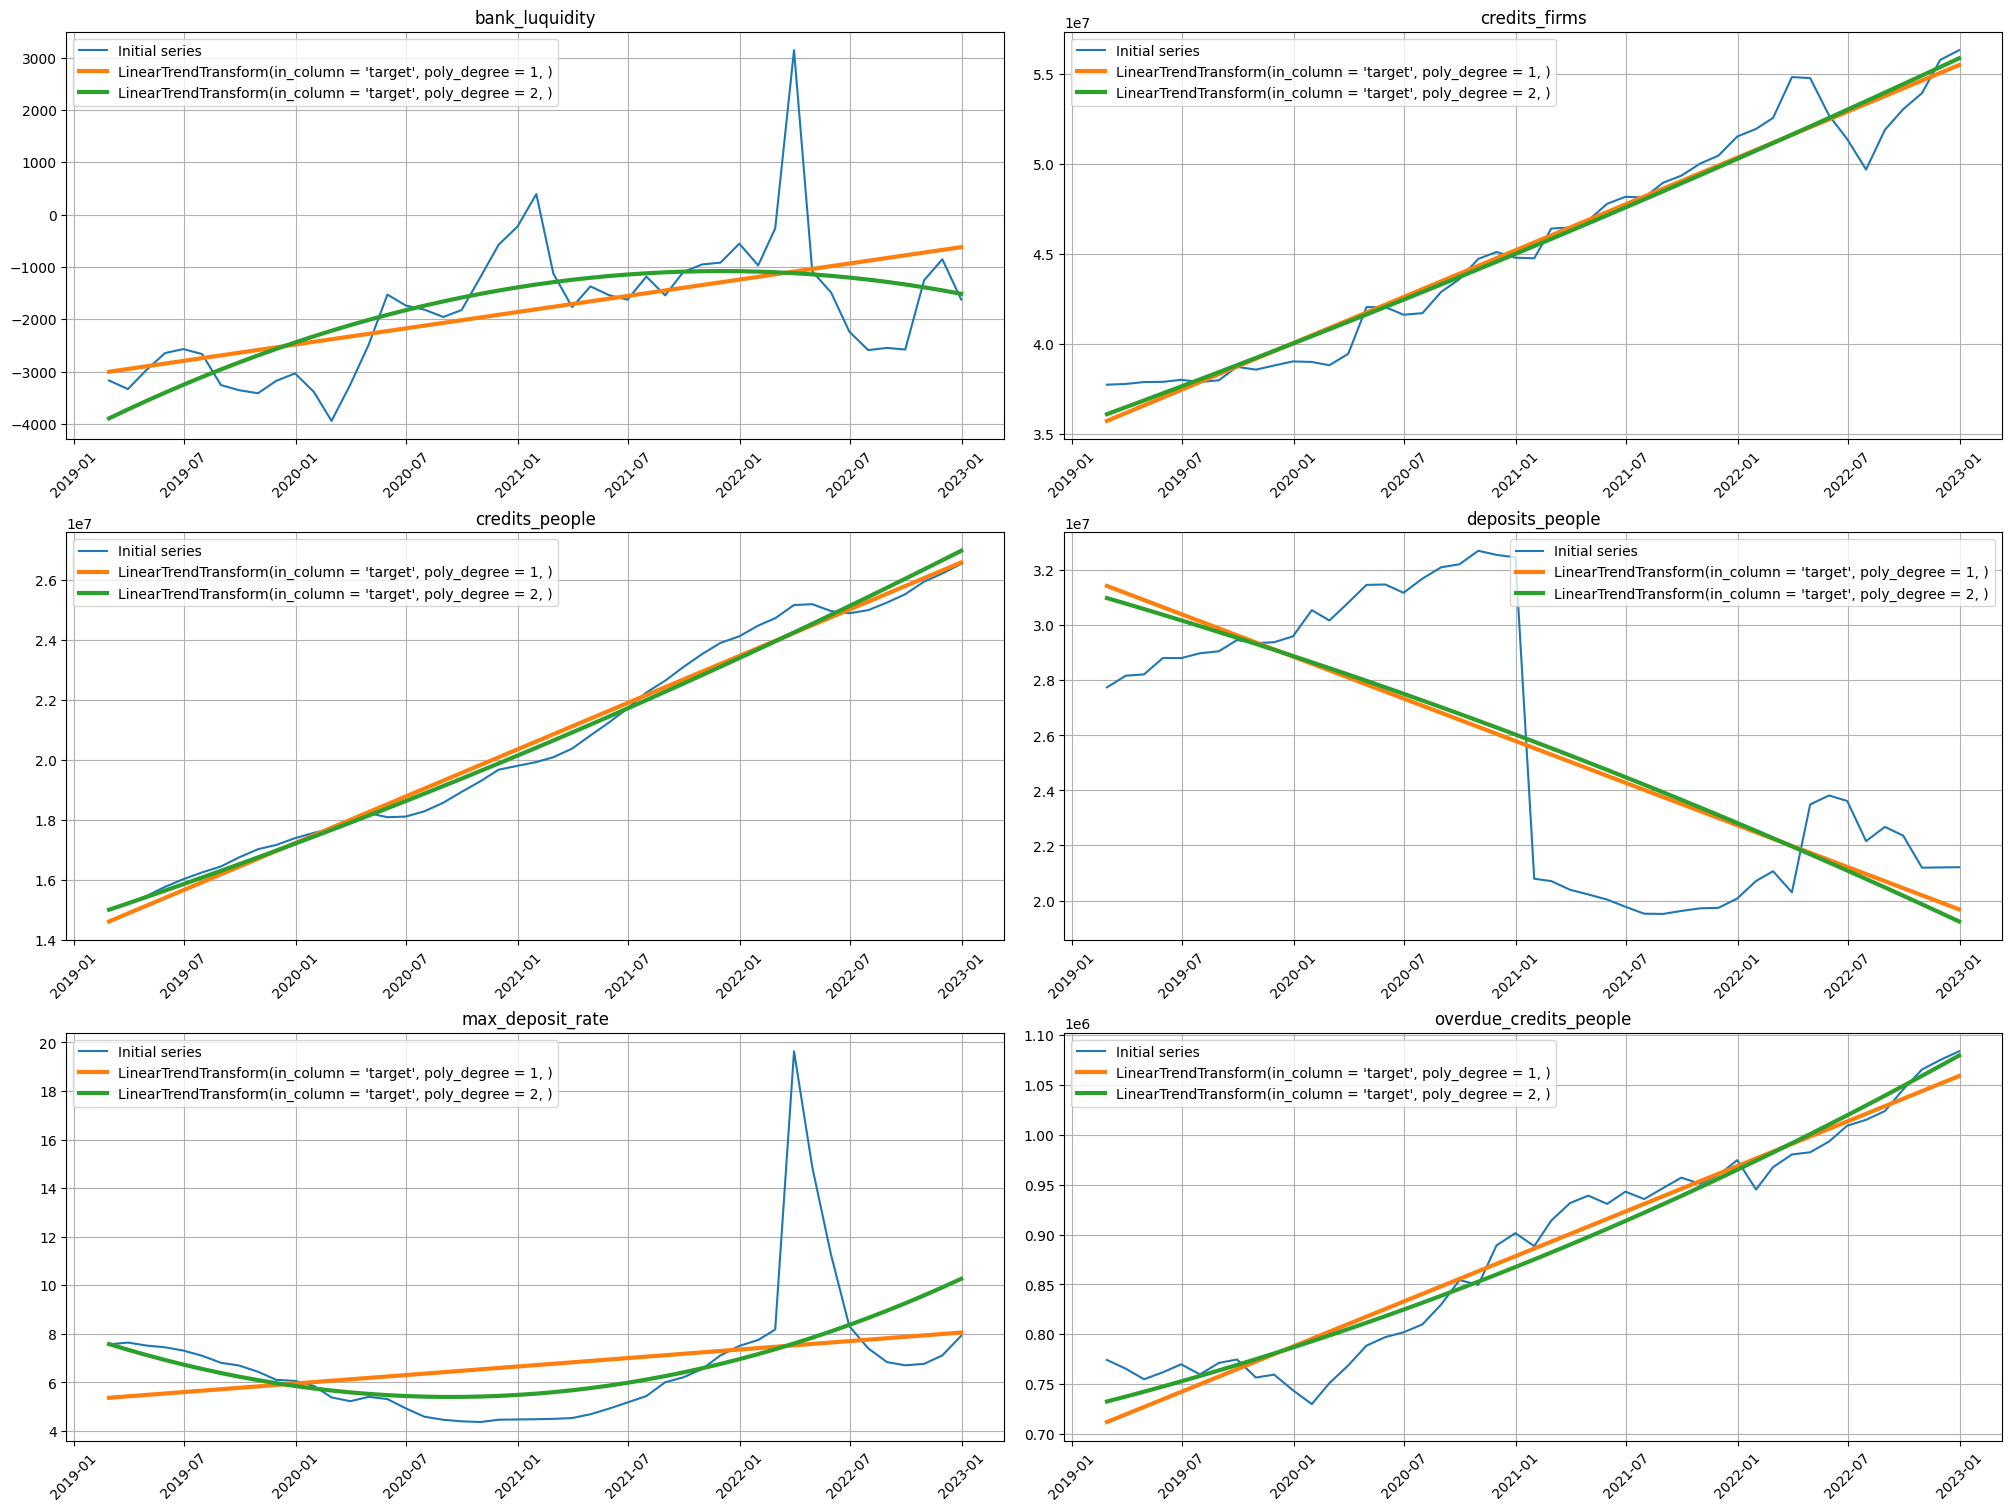

In [ ]:
trends = [
    LinearTrendTransform(in_column="target", poly_degree=1),
    LinearTrendTransform(in_column="target", poly_degree=2),
]

plot_trend(ts_plots, trend_transform=trends)

Сезонность

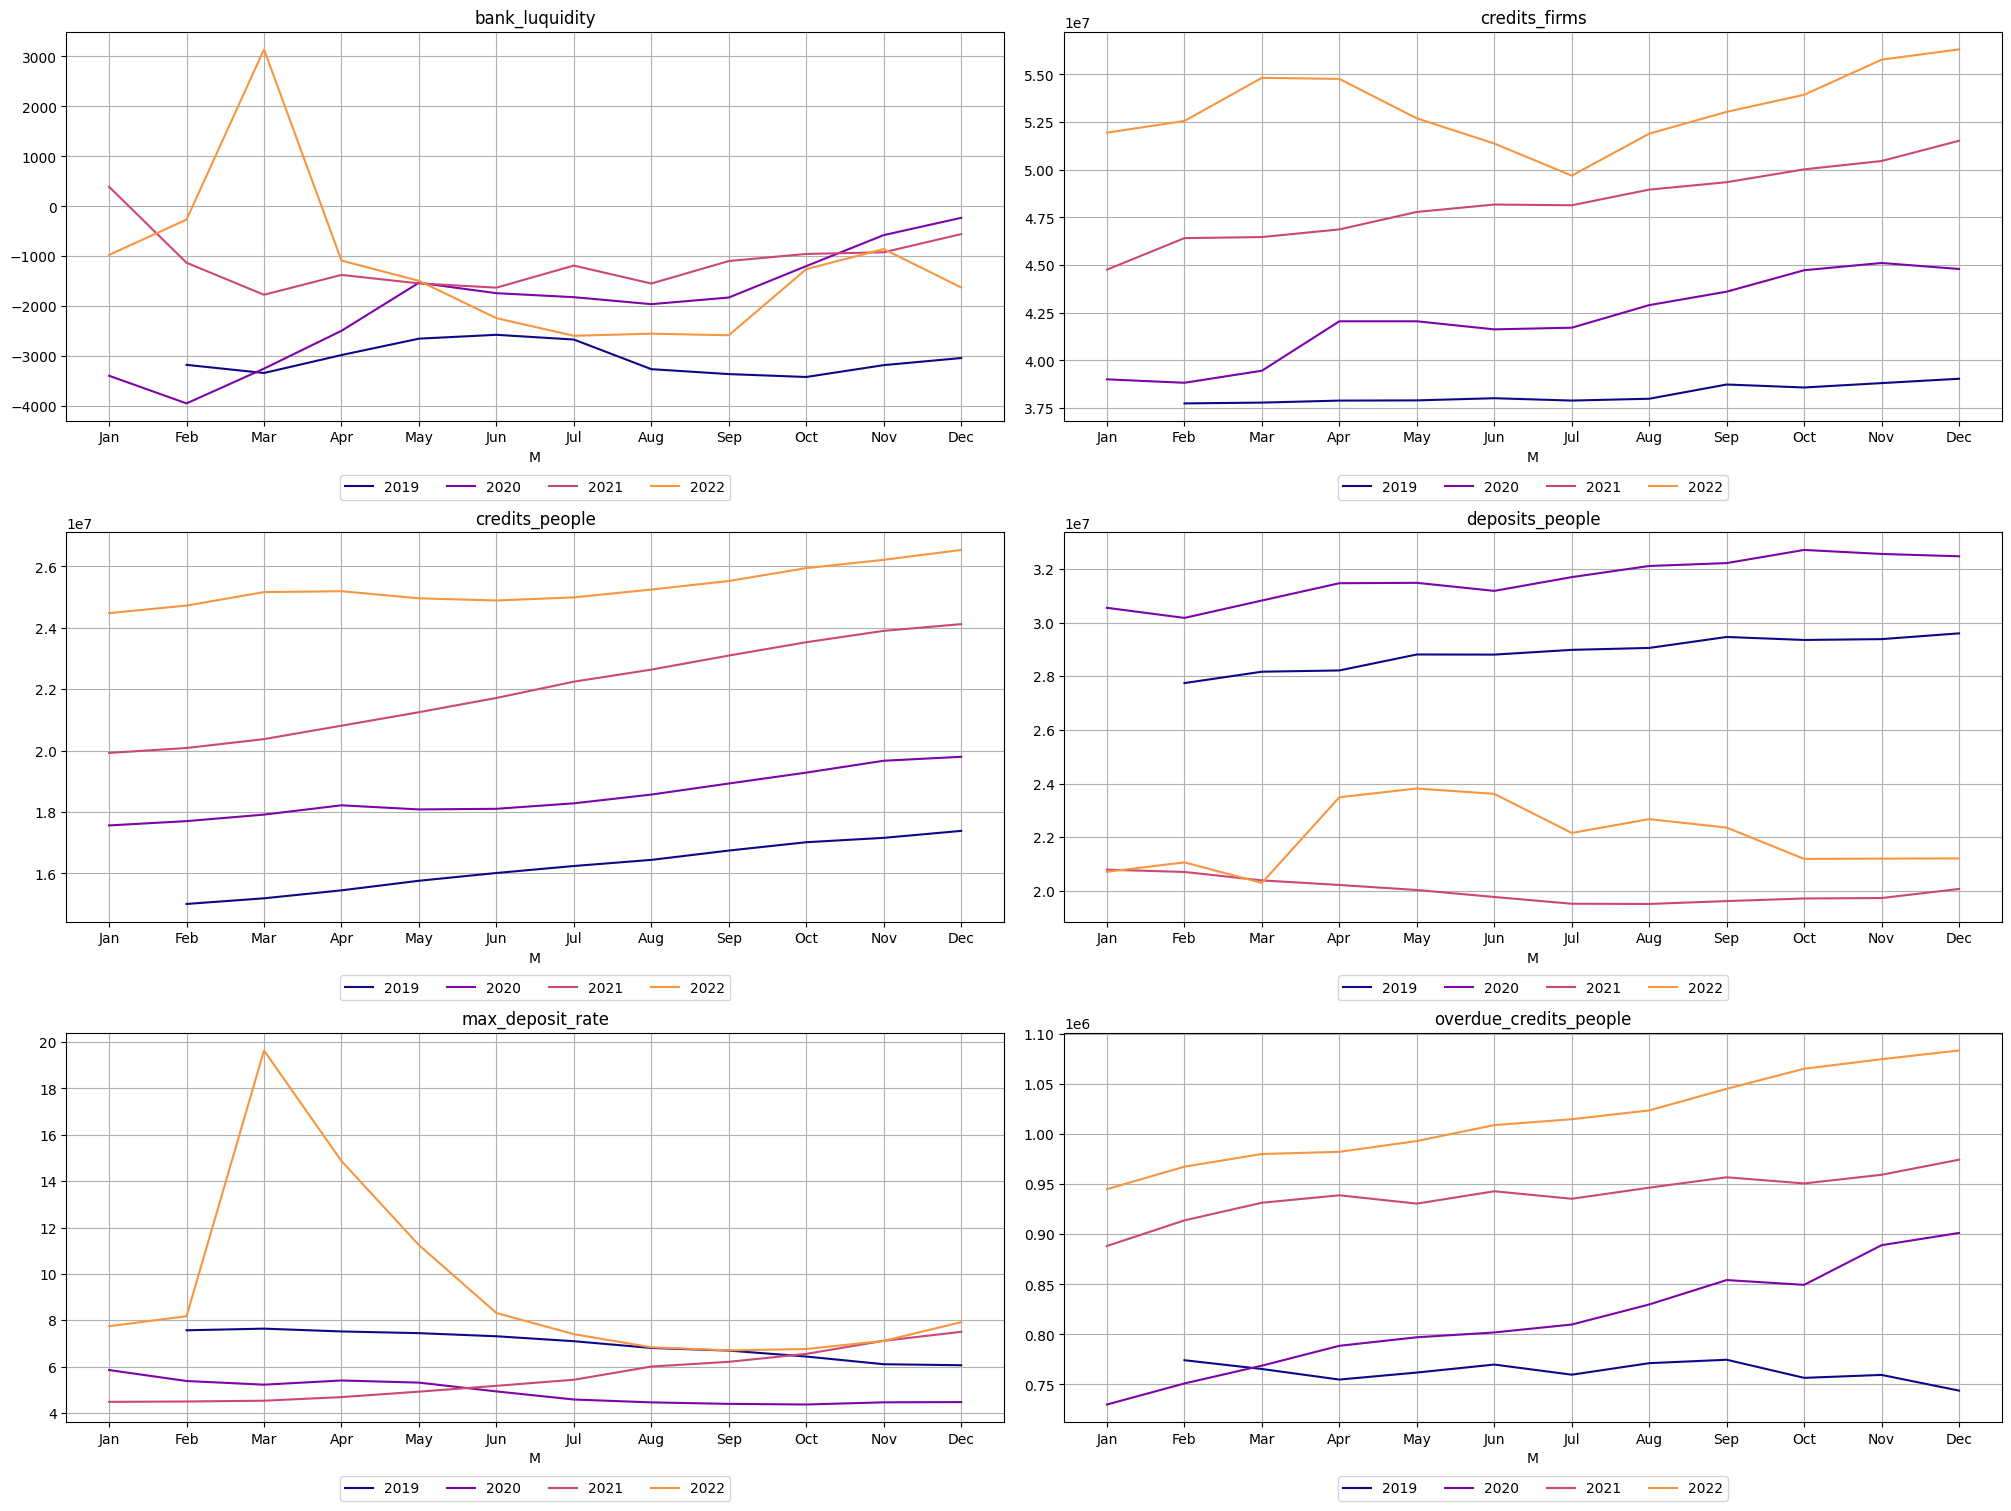

In [ ]:
seasonal_plot(ts=ts_plots, cycle="year")

Как-то совсем нестационарно - перейдем к разностям

In [178]:
bank_luquidity['value'].diff(periods=1)


0             NaN
1      -90.466190
2       86.300000
3       93.337060
4     -490.889441
         ...     
69    -470.022222
70    1531.979798
71     757.739091
72     254.810000
73    -135.640000
Name: value, Length: 74, dtype: float64

In [254]:

bank_luquidity = pd.read_csv('/content/bank_luquidity.csv')
credits_firms =  pd.read_csv('/content/credits_firms.csv')
credits_people =  pd.read_csv('/content/credits_people.csv')
deposits_people =  pd.read_csv('/content/deposits_people.csv')
deposits_firms =  pd.read_csv('/content/deposits_firms.csv')
df_key_rate =  pd.read_csv('/content/df_key_rate.csv')
max_deposit_rate =  pd.read_csv('/content/max_deposit_rate.csv')
overdue_credits_people =  pd.read_csv('/content/overdue_credits_people.csv')
bank_luquidity.head(5)

bank_luquidity['month_start']  = pd.offsets.MonthBegin() +  pd.to_datetime(bank_luquidity['date'], format='%d.%m.%Y') -  pd.offsets.DateOffset(months= 1)
bank_luquidity = bank_luquidity.groupby('month_start').agg({'value': 'mean'})
bank_luquidity.reset_index(inplace=True)
bank_luquidity["date"] = pd.to_datetime(bank_luquidity['month_start'], format='%Y-%m-%d').dt.strftime('%d.%m.%Y')
bank_luquidity.drop(columns=['month_start'], inplace=True)

# усредняем значения по месяцу

df_key_rate['month_start']  = pd.offsets.MonthBegin() +  pd.to_datetime(df_key_rate['date'], format='%d.%m.%Y') -  pd.offsets.DateOffset(months= 1)
df_key_rate = df_key_rate.groupby('month_start').agg({'rate': 'mean'})

ts = ['bank_luquidity', 'credits_firms', 'credits_people',  'deposits_people', 'max_deposit_rate', 'overdue_credits_people']
ts = pd.DataFrame(ts, columns= ['segment'])
credits_firms["segment"] = 'credits_firms'
bank_luquidity["segment"] = 'bank_luquidity'
credits_people["segment"] = 'credits_people'
deposits_firms["segment"] = 'deposits_firms'
deposits_people["segment"] = 'deposits_people'
max_deposit_rate["segment"] = 'max_deposit_rate'
overdue_credits_people["segment"] = 'overdue_credits_people'


credits_firms['value'] = credits_firms['value'].diff(periods=1)
credits_people['value'] = credits_people['value'].diff(periods=1)
overdue_credits_people['value'] = overdue_credits_people['value'].diff(periods=1)


series = pd.concat([credits_firms,bank_luquidity])
series = pd.concat([series,credits_people])
series = pd.concat([series,deposits_people])
series = pd.concat([series,max_deposit_rate])
series = pd.concat([series,overdue_credits_people])

series["timestamp"] = pd.to_datetime(series['date'], format='%d.%m.%Y')
series["target"] = series["value"]

series.drop(columns=['date', 'value'], inplace=True)

series = series[series['timestamp'] >= '2019-02-01']
series = series[series['timestamp'] <= '2022-12-31']
series['timestamp'] = pd.offsets.MonthEnd() + series['timestamp']
series = series[['timestamp', 'target', 'segment']]

df_key_rate.reset_index(inplace=True)
df_key_rate["timestamp"] = df_key_rate.month_start
df_key_rate.drop(columns=['month_start'], inplace=True)
df_key_rate['timestamp'] = pd.offsets.MonthEnd() + df_key_rate['timestamp']
df_key_rate['_tempkey'] = 1
ts['_tempkey'] = 1

df_key_rate = df_key_rate.merge(ts, on='_tempkey').drop('_tempkey', axis=1)
df_key_rate['regressor_0'] = df_key_rate['rate']
#df_key_rate['regressor_0'] = df_key_rate['regressor_0'].diff(periods=1)
df_key_rate.drop(columns=['rate'], inplace=True)

df_key_rate = df_key_rate[df_key_rate['timestamp'] >= '2019-02-01']
df_key_rate = df_key_rate[df_key_rate['timestamp'] <= '2022-12-31']


In [255]:
series_ds = TSDataset.to_dataset(series)
ts_plots = TSDataset(series_ds, freq="M")
ts_plots.info()

<class 'etna.datasets.TSDataset'>
num_segments: 6
num_exogs: 0
num_regressors: 0
num_known_future: 0
freq: M
                       start_timestamp end_timestamp  length  num_missing
segments                                                                 
bank_luquidity              2019-02-28    2022-12-31      47            0
credits_firms               2019-02-28    2022-12-31      47            0
credits_people              2019-03-31    2022-12-31      46            0
deposits_people             2019-02-28    2022-12-31      47            0
max_deposit_rate            2019-02-28    2022-12-31      47            0
overdue_credits_people      2019-03-31    2022-12-31      46            0


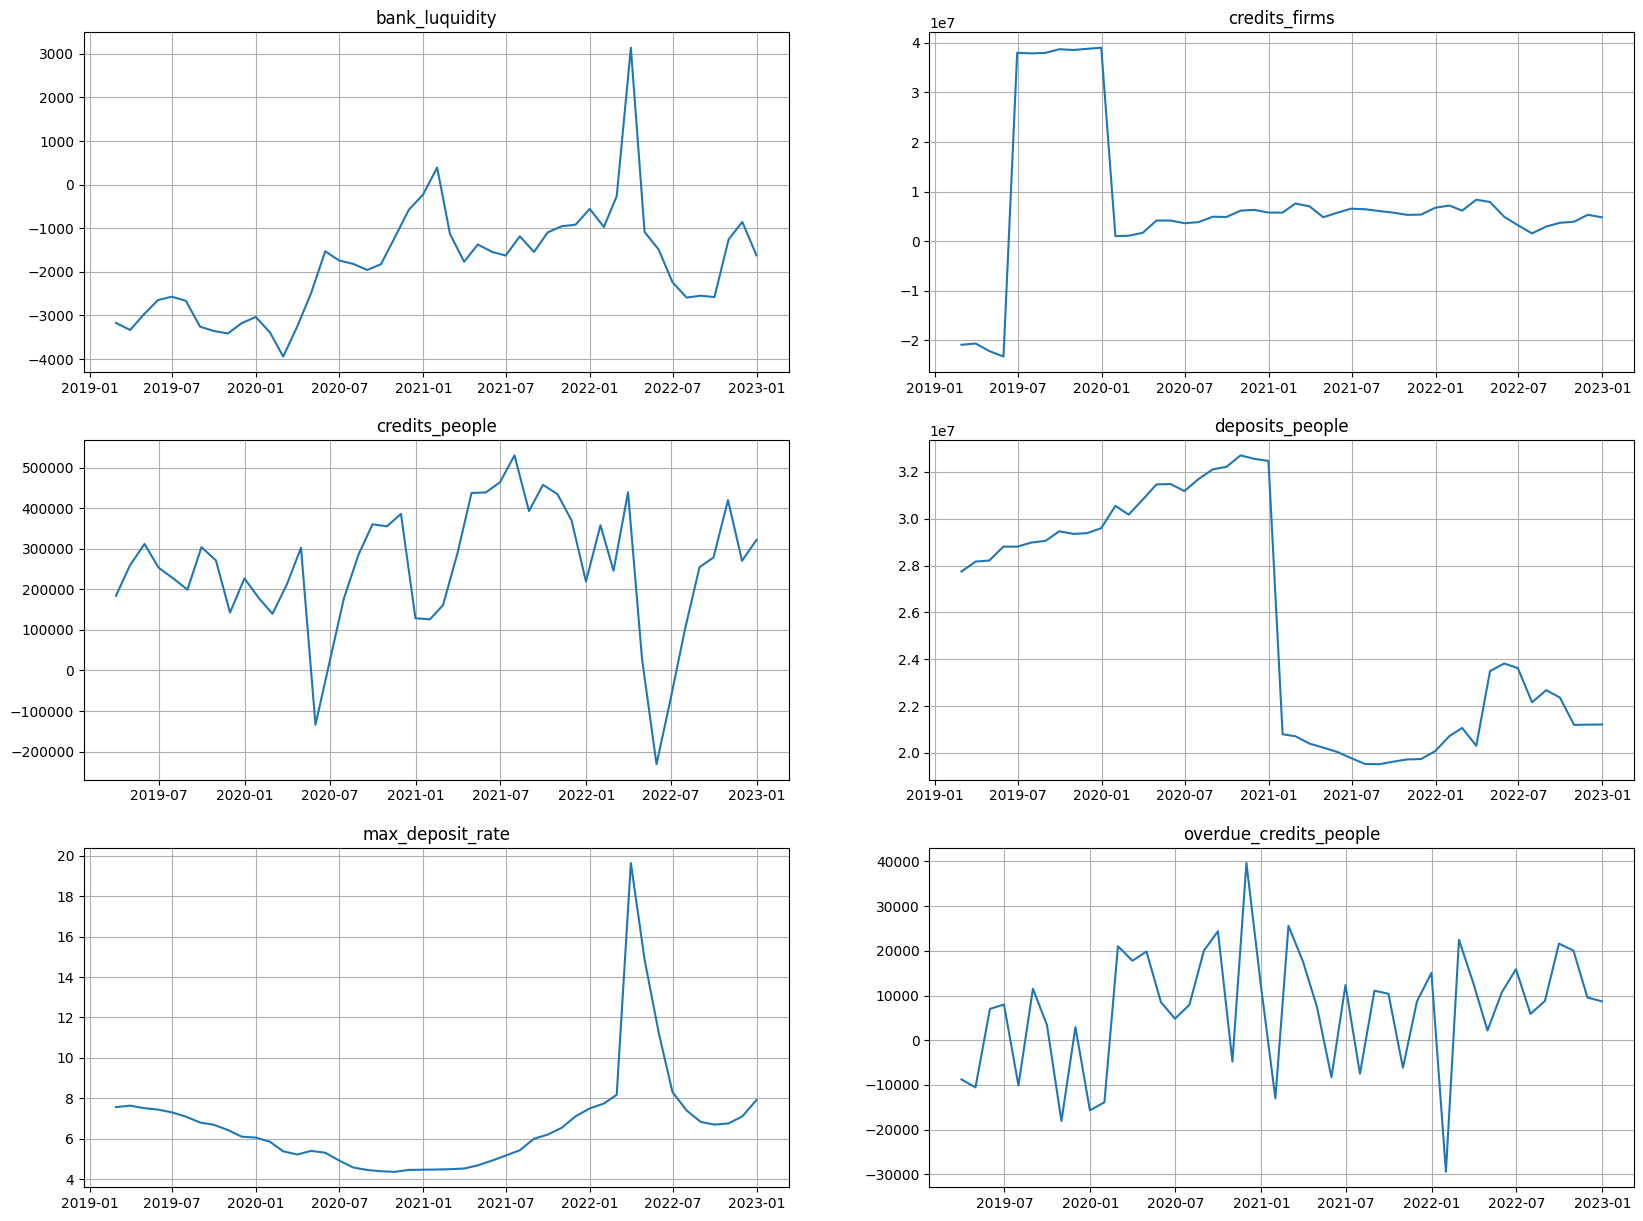

In [256]:
ts_plots.plot()

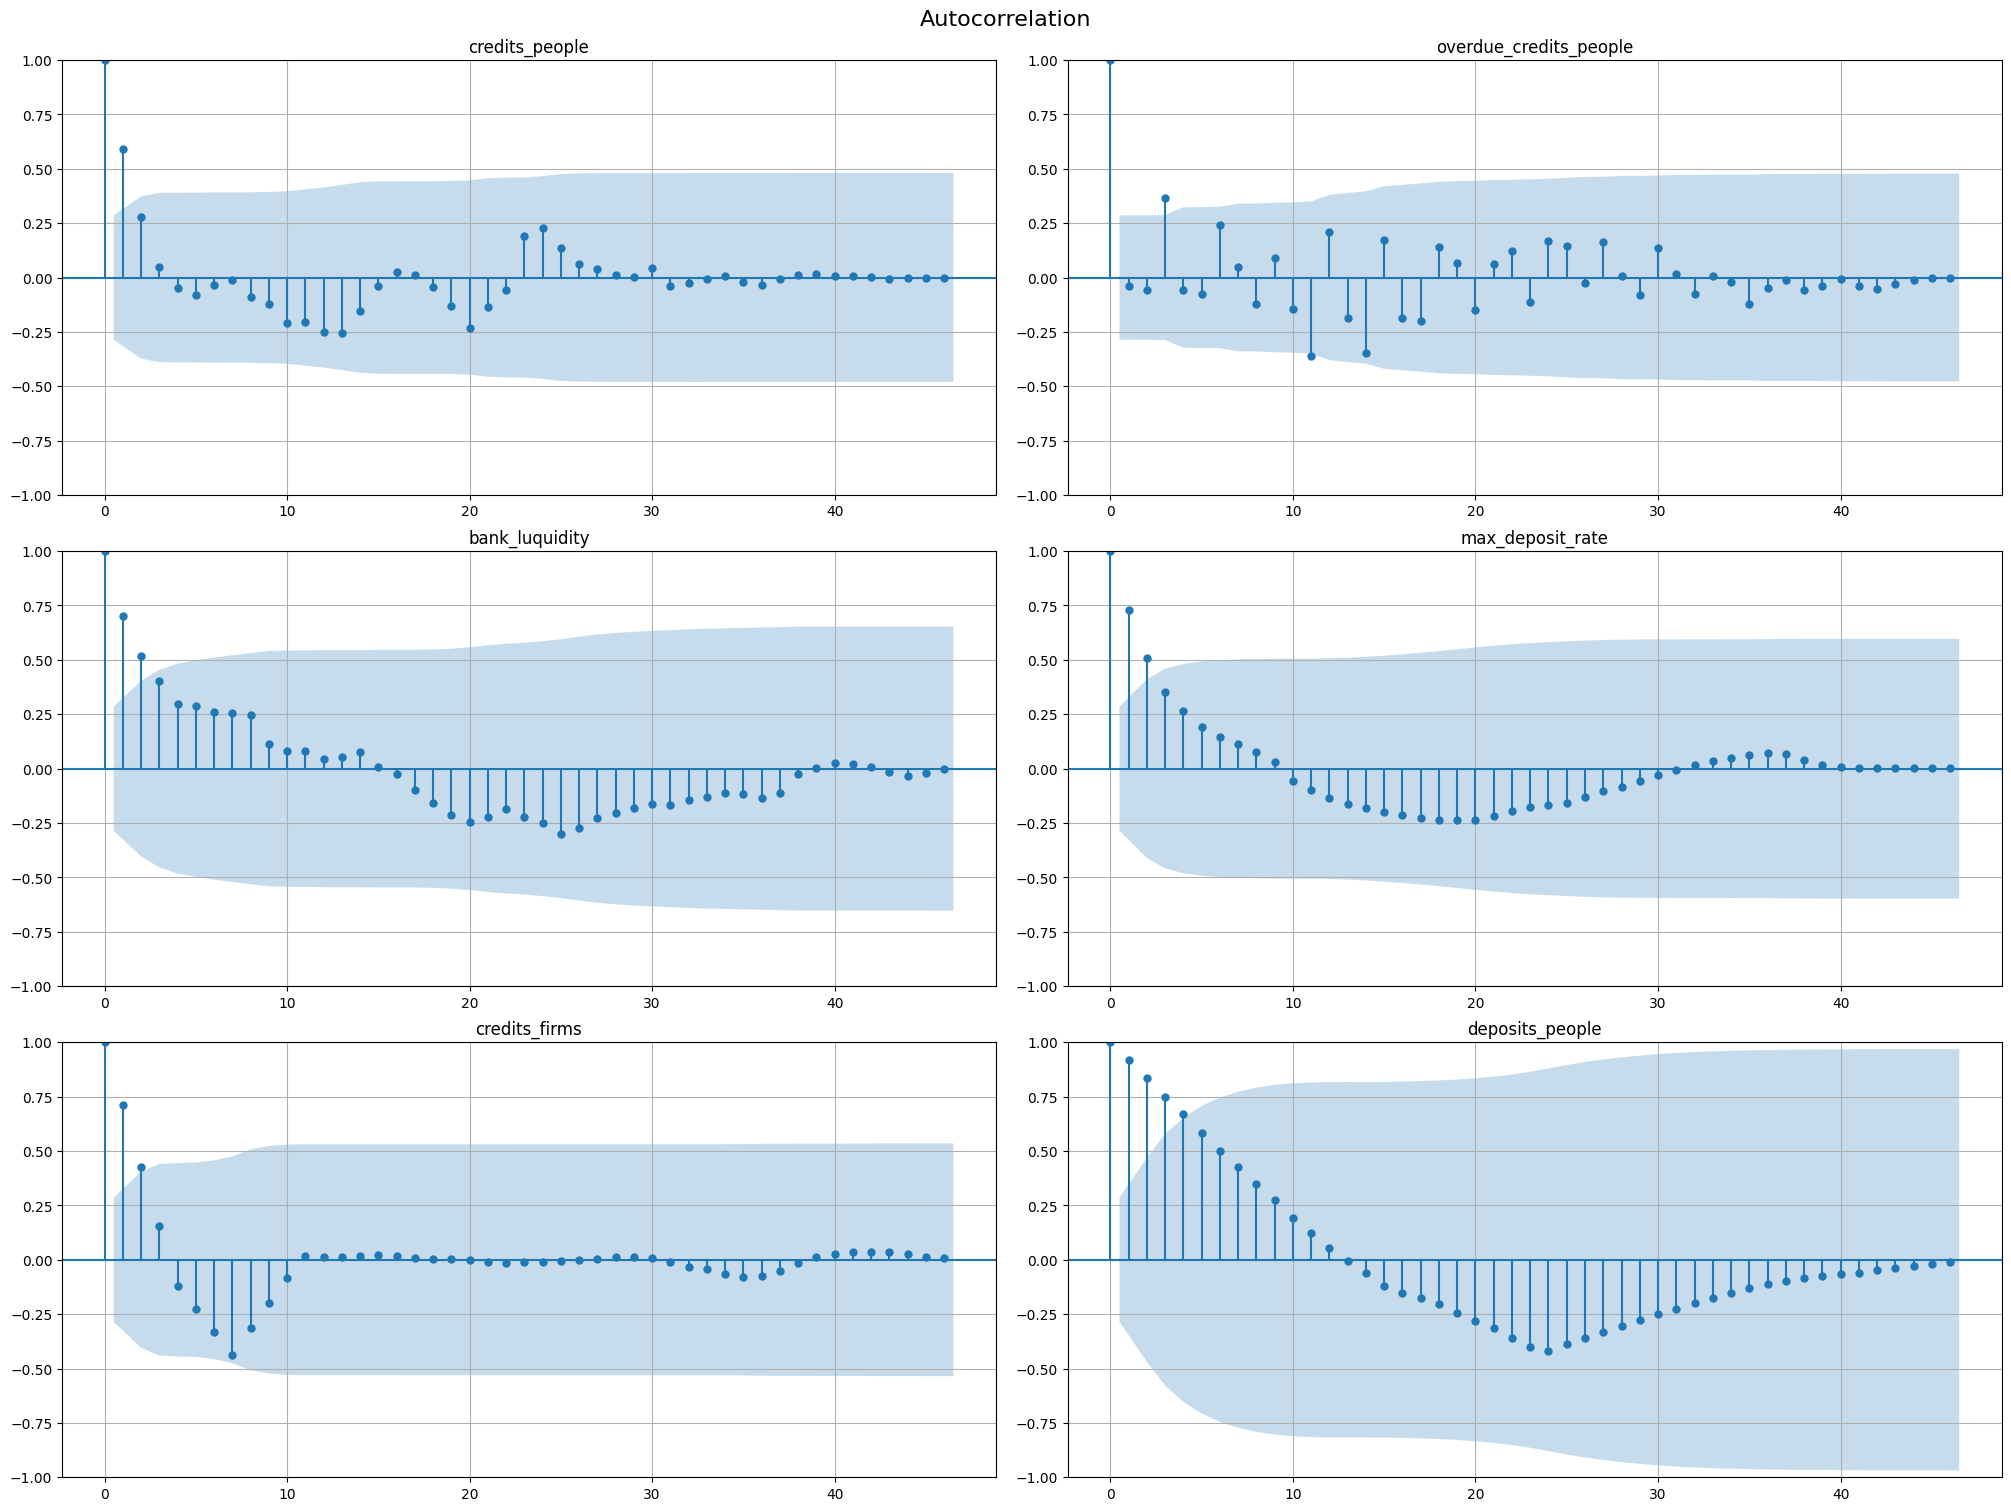

In [257]:
acf_plot(ts_plots, lags=46)

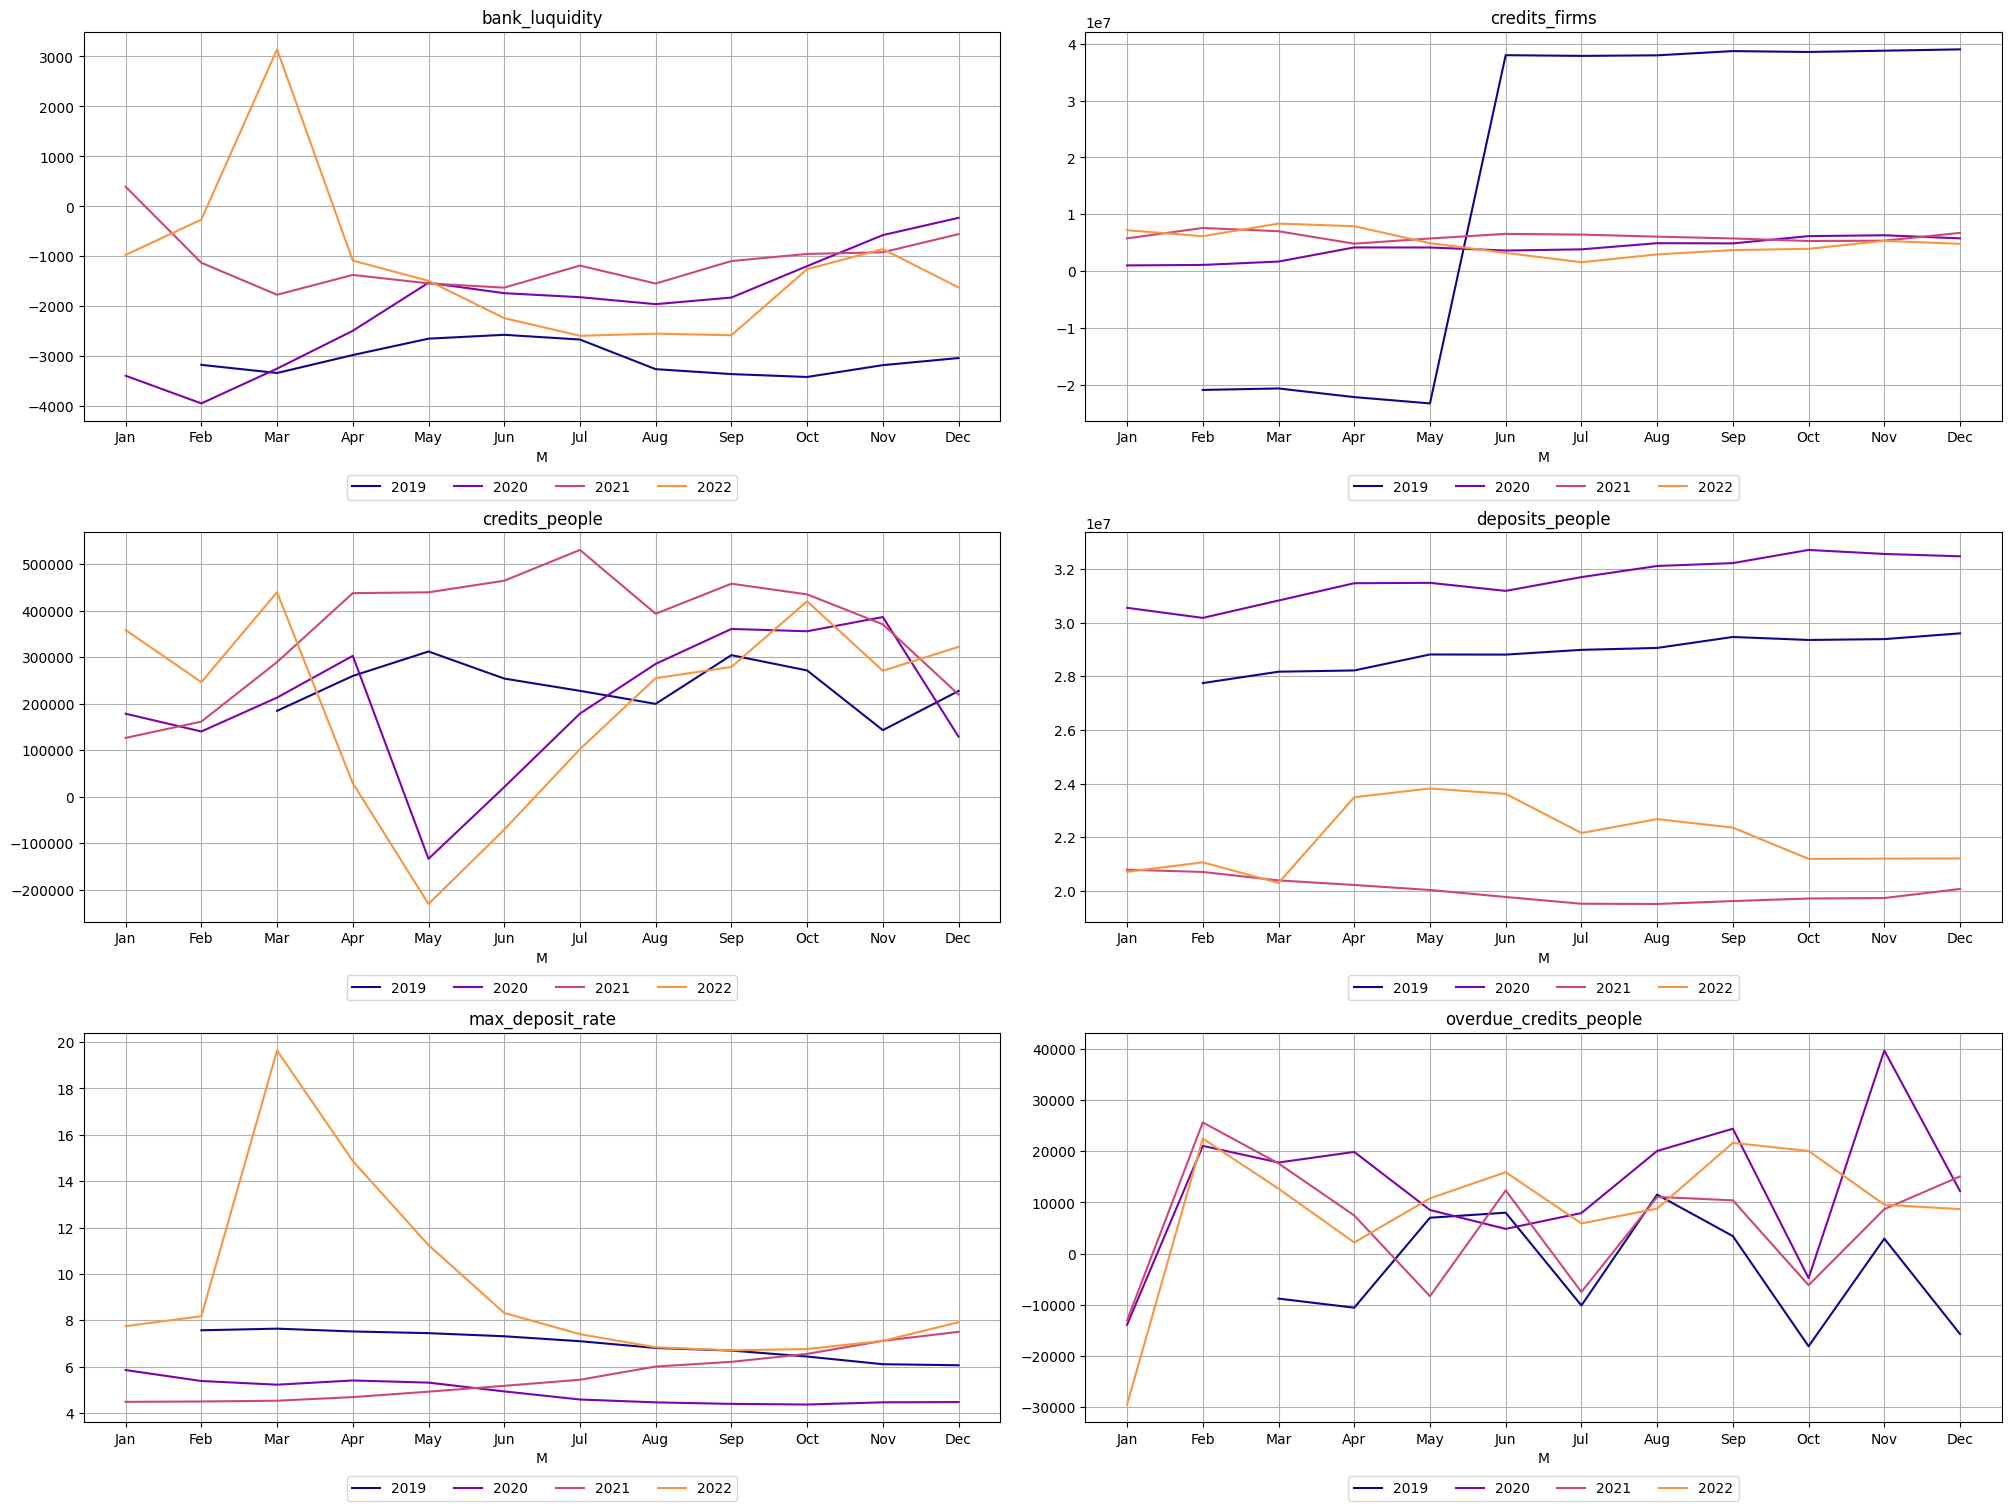

In [258]:
seasonal_plot(ts=ts_plots, cycle="year")

### **Наивная модель - baseline**

#### библиотеки моделей

In [259]:
from etna.pipeline import Pipeline
from etna.models import ProphetModel, NaiveModel, AutoARIMAModel, HoltModel, HoltWintersModel
from etna.metrics import SMAPE, MAE
from etna.analysis import plot_backtest
from etna.ensembles import DirectEnsemble, StackingEnsemble, VotingEnsemble
import etna.models as em
from etna.transforms import STLTransform, LagTransform, SegmentEncoderTransform, LogTransform, DateFlagsTransform, MeanTransform
from etna.models import LinearPerSegmentModel

In [260]:
series_ds = TSDataset.to_dataset(series)

df_regressors = TSDataset.to_dataset(df_key_rate)
tsdataset_naive = TSDataset(series_ds, freq="M")
tsdataset_naive.info()

<class 'etna.datasets.TSDataset'>
num_segments: 6
num_exogs: 0
num_regressors: 0
num_known_future: 0
freq: M
                       start_timestamp end_timestamp  length  num_missing
segments                                                                 
bank_luquidity              2019-02-28    2022-12-31      47            0
credits_firms               2019-02-28    2022-12-31      47            0
credits_people              2019-03-31    2022-12-31      46            0
deposits_people             2019-02-28    2022-12-31      47            0
max_deposit_rate            2019-02-28    2022-12-31      47            0
overdue_credits_people      2019-03-31    2022-12-31      46            0


In [261]:
pipeline_naive = Pipeline(model=NaiveModel(), horizon=1)
metrics_naive, forecast_naive, _ = pipeline_naive.backtest(ts=tsdataset_naive, metrics=[MAE(), SMAPE()], n_folds=3)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s finished


In [262]:
metrics_naive_df =  metrics_naive.groupby('segment').agg({'MAE': 'mean', 'SMAPE':'mean'})
metrics_naive_df

,MAE,SMAPE
segment,,
bank_luquidity,830.601443,56.341306
credits_firms,715704.934333,15.525906
credits_people,114077.333333,33.717947
deposits_people,394304.390000,1.811374
max_deposit_rate,0.405000,5.547205
overdue_credits_people,4309.666667,29.308585


In [263]:
metrics_naive.mean()

MAE            204871.221796
SMAPE              23.708720
fold_number         1.000000
dtype: float64

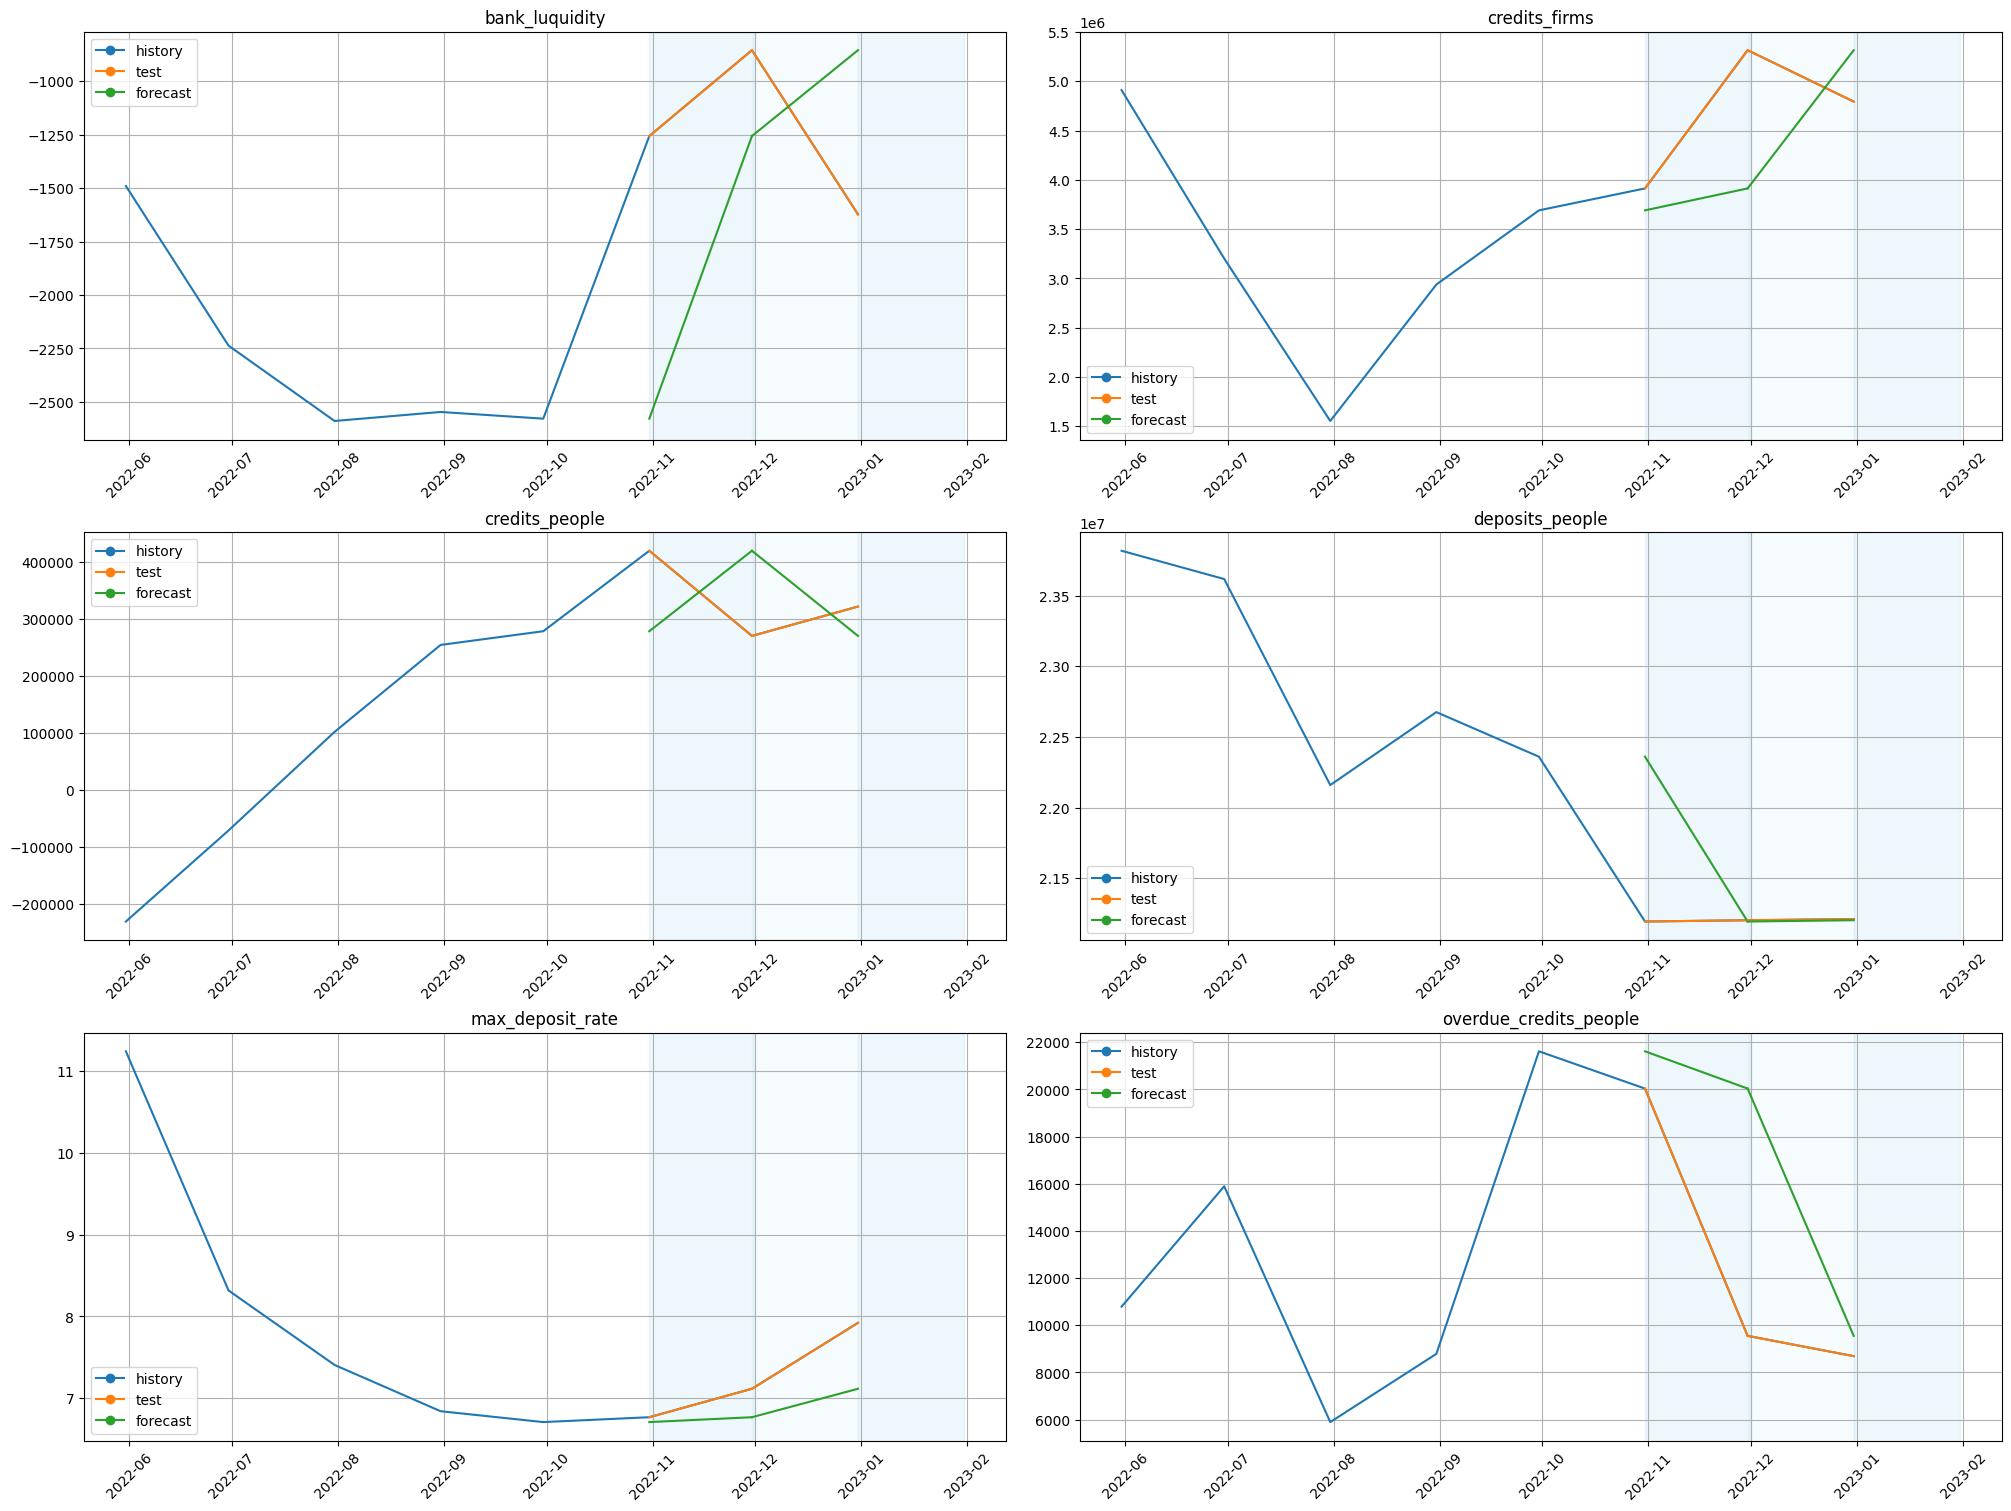

In [264]:
plot_backtest(forecast_naive, tsdataset_naive, history_len=5)

###**SARIMAX**


<Axes: xlabel='timestamp'>

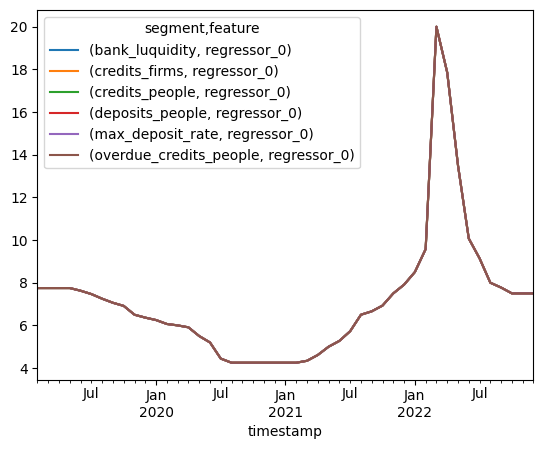

In [265]:
df_regressors.plot()

In [266]:
series_ds = TSDataset.to_dataset(series)
df_regressors = TSDataset.to_dataset(df_key_rate)
tsdataset = TSDataset(series_ds, freq="M", df_exog=df_regressors)
tsdataset.info()

<class 'etna.datasets.TSDataset'>
num_segments: 6
num_exogs: 1
num_regressors: 0
num_known_future: 0
freq: M
                       start_timestamp end_timestamp  length  num_missing
segments                                                                 
bank_luquidity              2019-02-28    2022-12-31      47            0
credits_firms               2019-02-28    2022-12-31      47            0
credits_people              2019-03-31    2022-12-31      46            0
deposits_people             2019-02-28    2022-12-31      47            0
max_deposit_rate            2019-02-28    2022-12-31      47            0
overdue_credits_people      2019-03-31    2022-12-31      46            0


In [269]:
transforms = [
    LagTransform(in_column="target", lags=list(range(1, 3)), out_column="lag"),
]
pipeline_sarimax = Pipeline(model=em.SARIMAXModel(), transforms=transforms, horizon=1)
metrics_sarimax, forecast_sarimax, _ = pipeline_sarimax.backtest(ts=tsdataset, metrics=[MAE(), SMAPE()], n_folds=3)
metrics_sarimax_df = metrics_sarimax.groupby('segment').agg({'MAE': 'mean', 'SMAPE':'mean'})
metrics_sarimax_df

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    9.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   13.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   16.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   16.4s finished


,MAE,SMAPE
segment,,
bank_luquidity,5.853447e+02,41.271528
credits_firms,1.258324e+06,23.839509
credits_people,1.639241e+05,64.818864
deposits_people,7.232424e+05,3.400092
max_deposit_rate,4.879759e-01,6.673902
overdue_credits_people,1.791181e+04,126.917795


In [270]:
metrics_sarimax_df.mean()

MAE      360664.762546
SMAPE        44.486948
dtype: float64

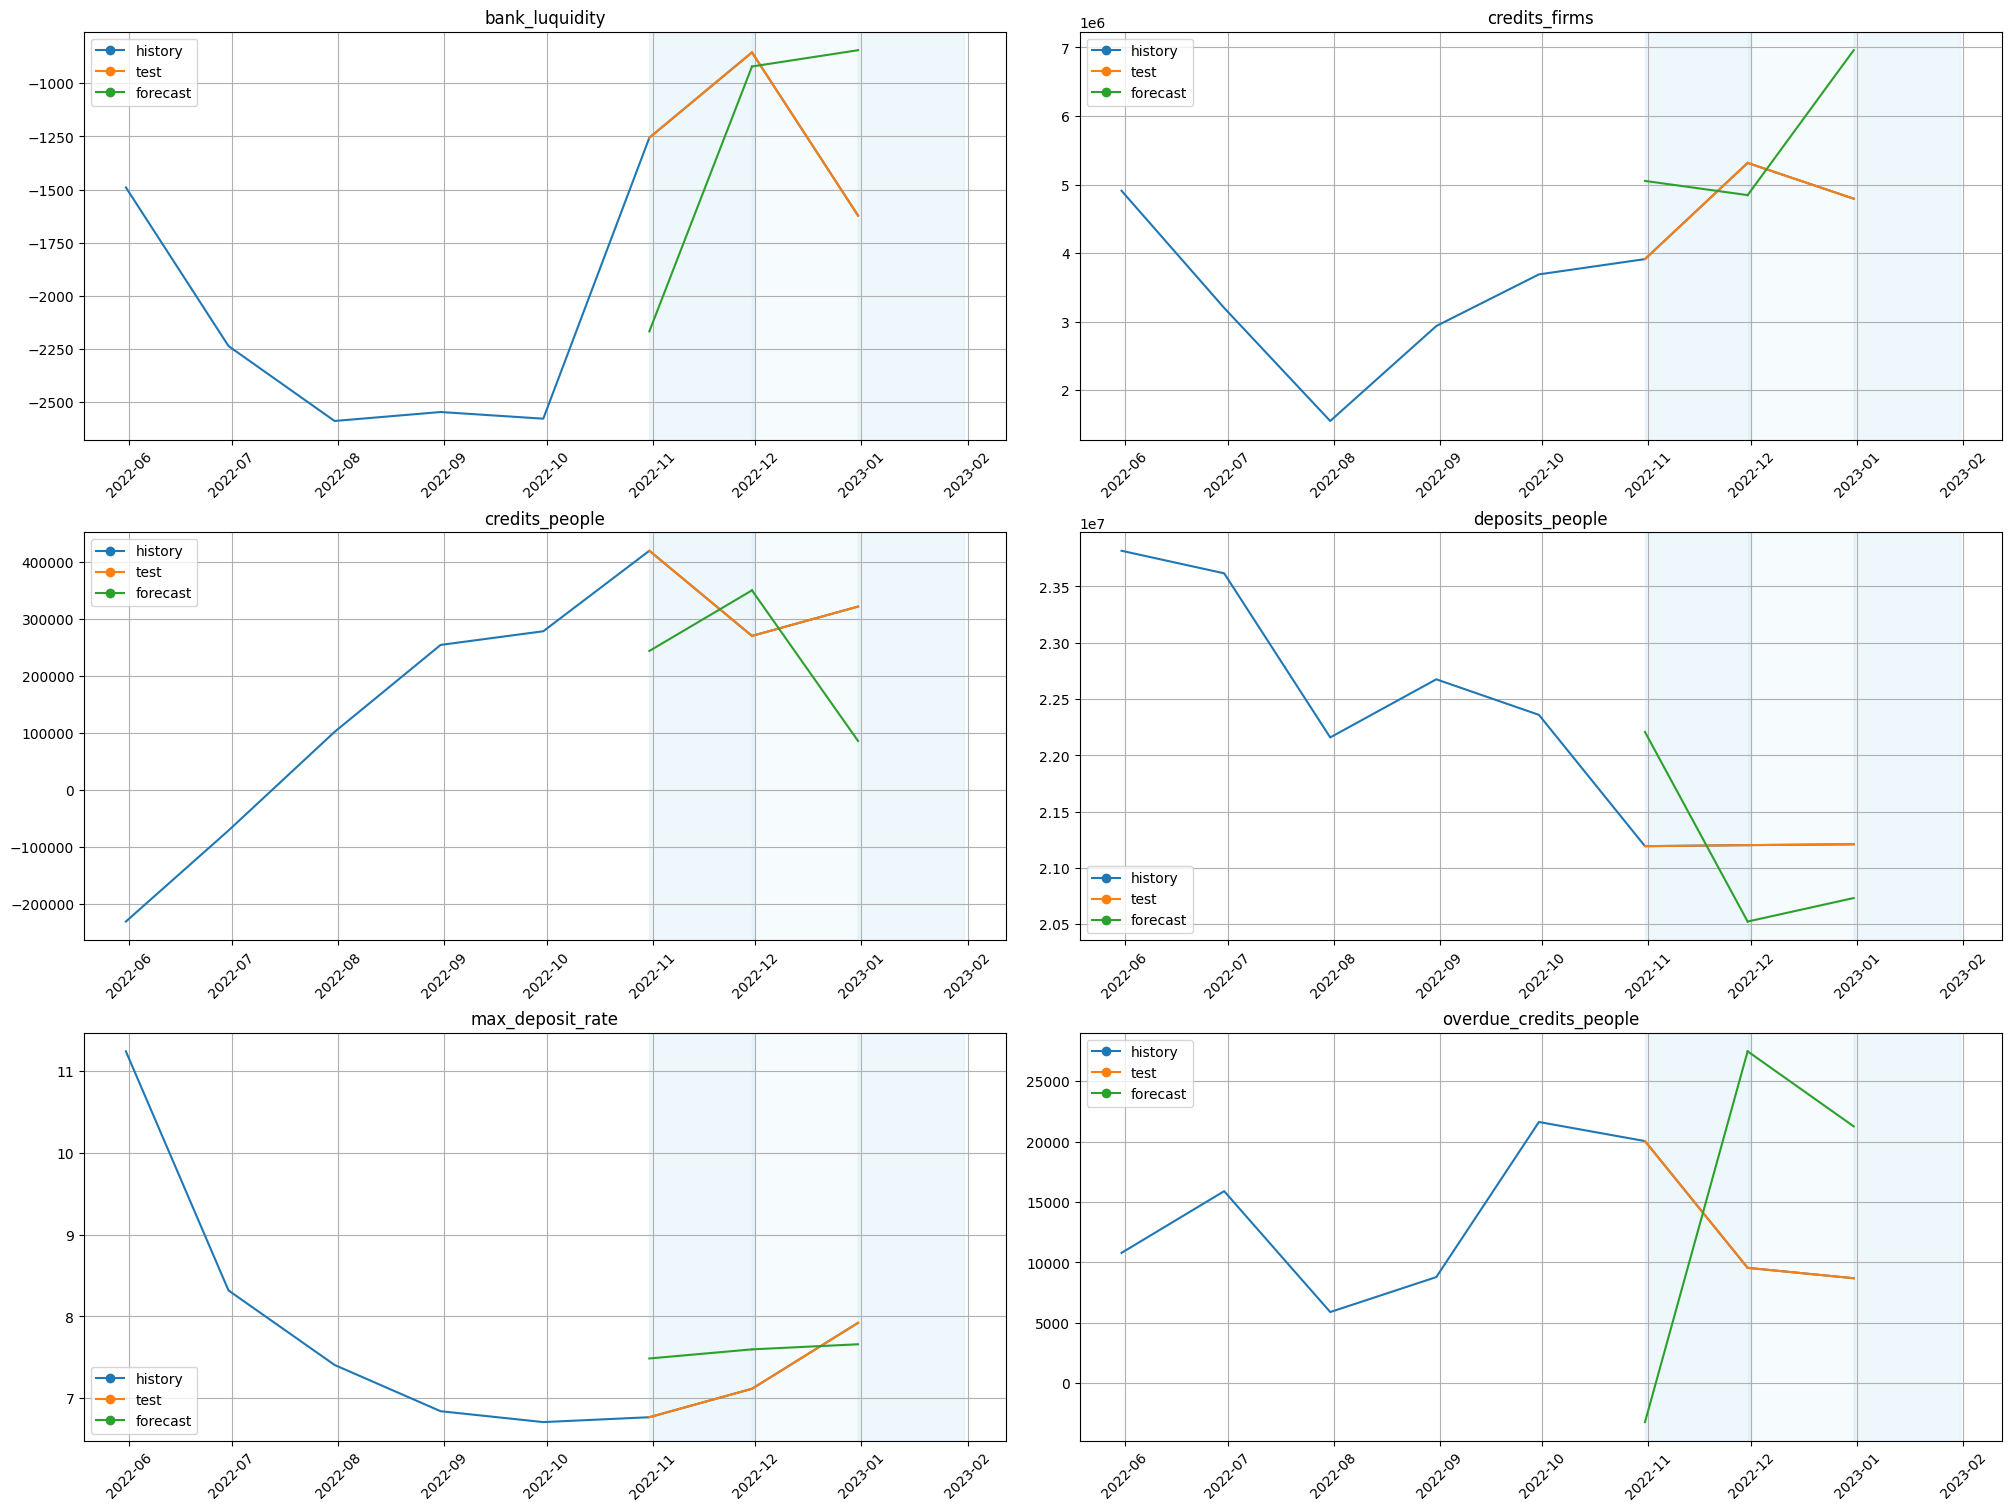

In [271]:
plot_backtest(forecast_sarimax, tsdataset, history_len=5)


In [272]:
series_ds = TSDataset.to_dataset(series)
tsdataset_without_rate = TSDataset(series_ds, freq="M")
transforms = [
    LagTransform(in_column="target", lags=list(range(1, 3)), out_column="lag"),
]
pipeline_sarimax = Pipeline(model=em.SARIMAXModel(), transforms=transforms, horizon=1)
metrics_sarimax, forecast_sarimax, _ = pipeline_sarimax.backtest(ts=tsdataset_without_rate, metrics=[MAE(), SMAPE()], n_folds=3)
metrics_sarimax_df = metrics_sarimax.groupby('segment').agg({'MAE': 'mean', 'SMAPE':'mean'})
metrics_sarimax_df

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   13.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   17.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   17.1s finished


,MAE,SMAPE
segment,,
bank_luquidity,5.853447e+02,41.271528
credits_firms,1.258324e+06,23.839509
credits_people,1.639241e+05,64.818864
deposits_people,7.232424e+05,3.400092
max_deposit_rate,4.879759e-01,6.673902
overdue_credits_people,1.791181e+04,126.917795


In [273]:
metrics_sarimax_df.mean()

MAE      360664.762546
SMAPE        44.486948
dtype: float64

###  AutoARIMAModel

In [274]:
transforms = [
    LagTransform(in_column="target", lags=list(range(1, 3)), out_column="lag"),
]

model=AutoARIMAModel()

pipeline_auto_arima = Pipeline(model=model, transforms=transforms, horizon=1)
metrics_auto_arima, forecast_auto_arima, _ = pipeline_auto_arima.backtest(ts=tsdataset, metrics=[MAE(), SMAPE()], n_folds=3)

metrics_auto_arima_df = metrics_auto_arima.groupby('segment').agg({'MAE': 'mean', 'SMAPE':'mean'})
metrics_auto_arima_df

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   11.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   22.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   28.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   28.4s finished


,MAE,SMAPE
segment,,
bank_luquidity,753.054674,51.425027
credits_firms,970539.013750,19.149673
credits_people,103306.887658,30.782803
deposits_people,452125.918413,2.098741
max_deposit_rate,0.476548,6.581268
overdue_credits_people,9956.671780,89.381032


In [275]:
metrics_auto_arima_df.mean()

MAE      256113.670471
SMAPE        33.236424
dtype: float64

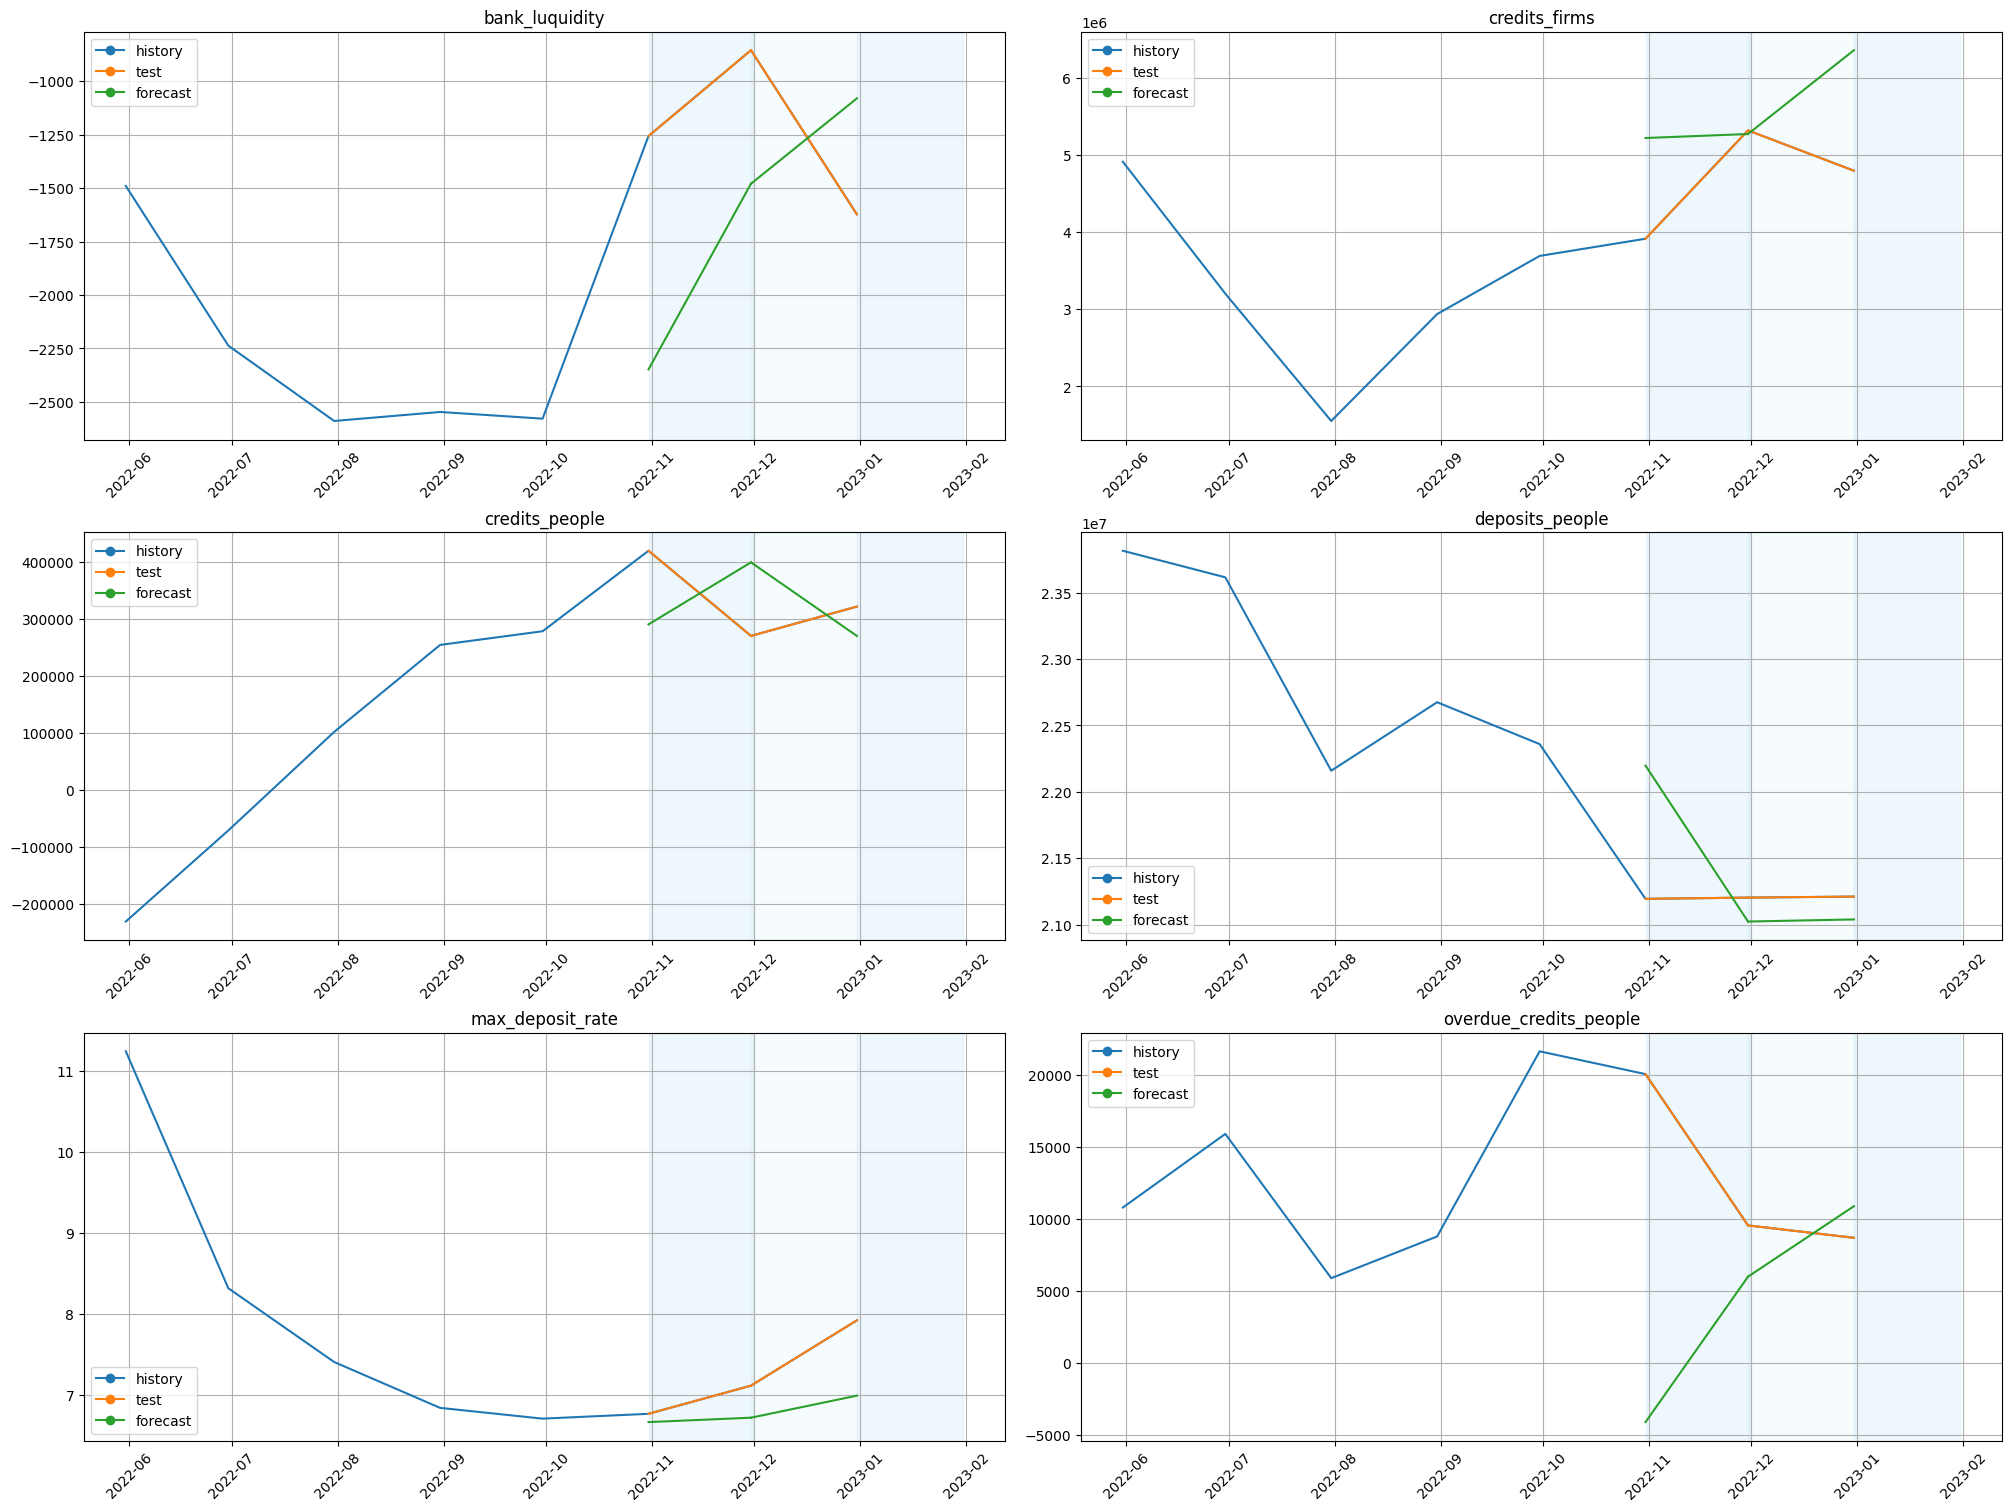

In [276]:
plot_backtest(forecast_auto_arima, tsdataset, history_len=5)


In [277]:
transforms = [
    LagTransform(in_column="target", lags=list(range(1, 3)), out_column="lag"),
]

model=AutoARIMAModel()

pipeline_auto_arima = Pipeline(model=model, transforms=transforms, horizon=1)
metrics_auto_arima, forecast_auto_arima, _ = pipeline_auto_arima.backtest(ts=tsdataset_without_rate, metrics=[MAE(), SMAPE()], n_folds=3)

metrics_auto_arima_df = metrics_auto_arima.groupby('segment').agg({'MAE': 'mean', 'SMAPE':'mean'})
metrics_auto_arima_df

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   12.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   25.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   32.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   32.8s finished


,MAE,SMAPE
segment,,
bank_luquidity,753.054674,51.425027
credits_firms,970539.013750,19.149673
credits_people,103306.887658,30.782803
deposits_people,452125.918413,2.098741
max_deposit_rate,0.476548,6.581268
overdue_credits_people,9956.671780,89.381032


In [278]:
metrics_auto_arima_df.mean()

MAE      256113.670471
SMAPE        33.236424
dtype: float64

### **CatBoostPerSegmentModel**

In [279]:
transforms = [
    LagTransform(in_column="target", lags=list(range(1, 3)), out_column="lag"),
]

model = em.CatBoostPerSegmentModel()

pipeline_cb_ps = Pipeline(model=model, transforms=transforms, horizon=1)

metrics_cb_ps, forecast_cb_ps, _ = pipeline_cb_ps.backtest(ts=tsdataset, metrics=[MAE(), SMAPE()], n_folds=3)

metrics_cb_ps_df = metrics_cb_ps.groupby('segment').agg({'MAE': 'mean', 'SMAPE':'mean'})
metrics_cb_ps_df

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    4.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    7.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    7.8s finished


,MAE,SMAPE
segment,,
bank_luquidity,999.528013,69.576133
credits_firms,935216.143941,20.309593
credits_people,93456.927594,30.481463
deposits_people,390785.933479,1.796221
max_deposit_rate,0.462832,6.369305
overdue_credits_people,9855.520005,96.544384


In [280]:
metrics_cb_ps_df.mean()

MAE      238385.752644
SMAPE        37.512850
dtype: float64

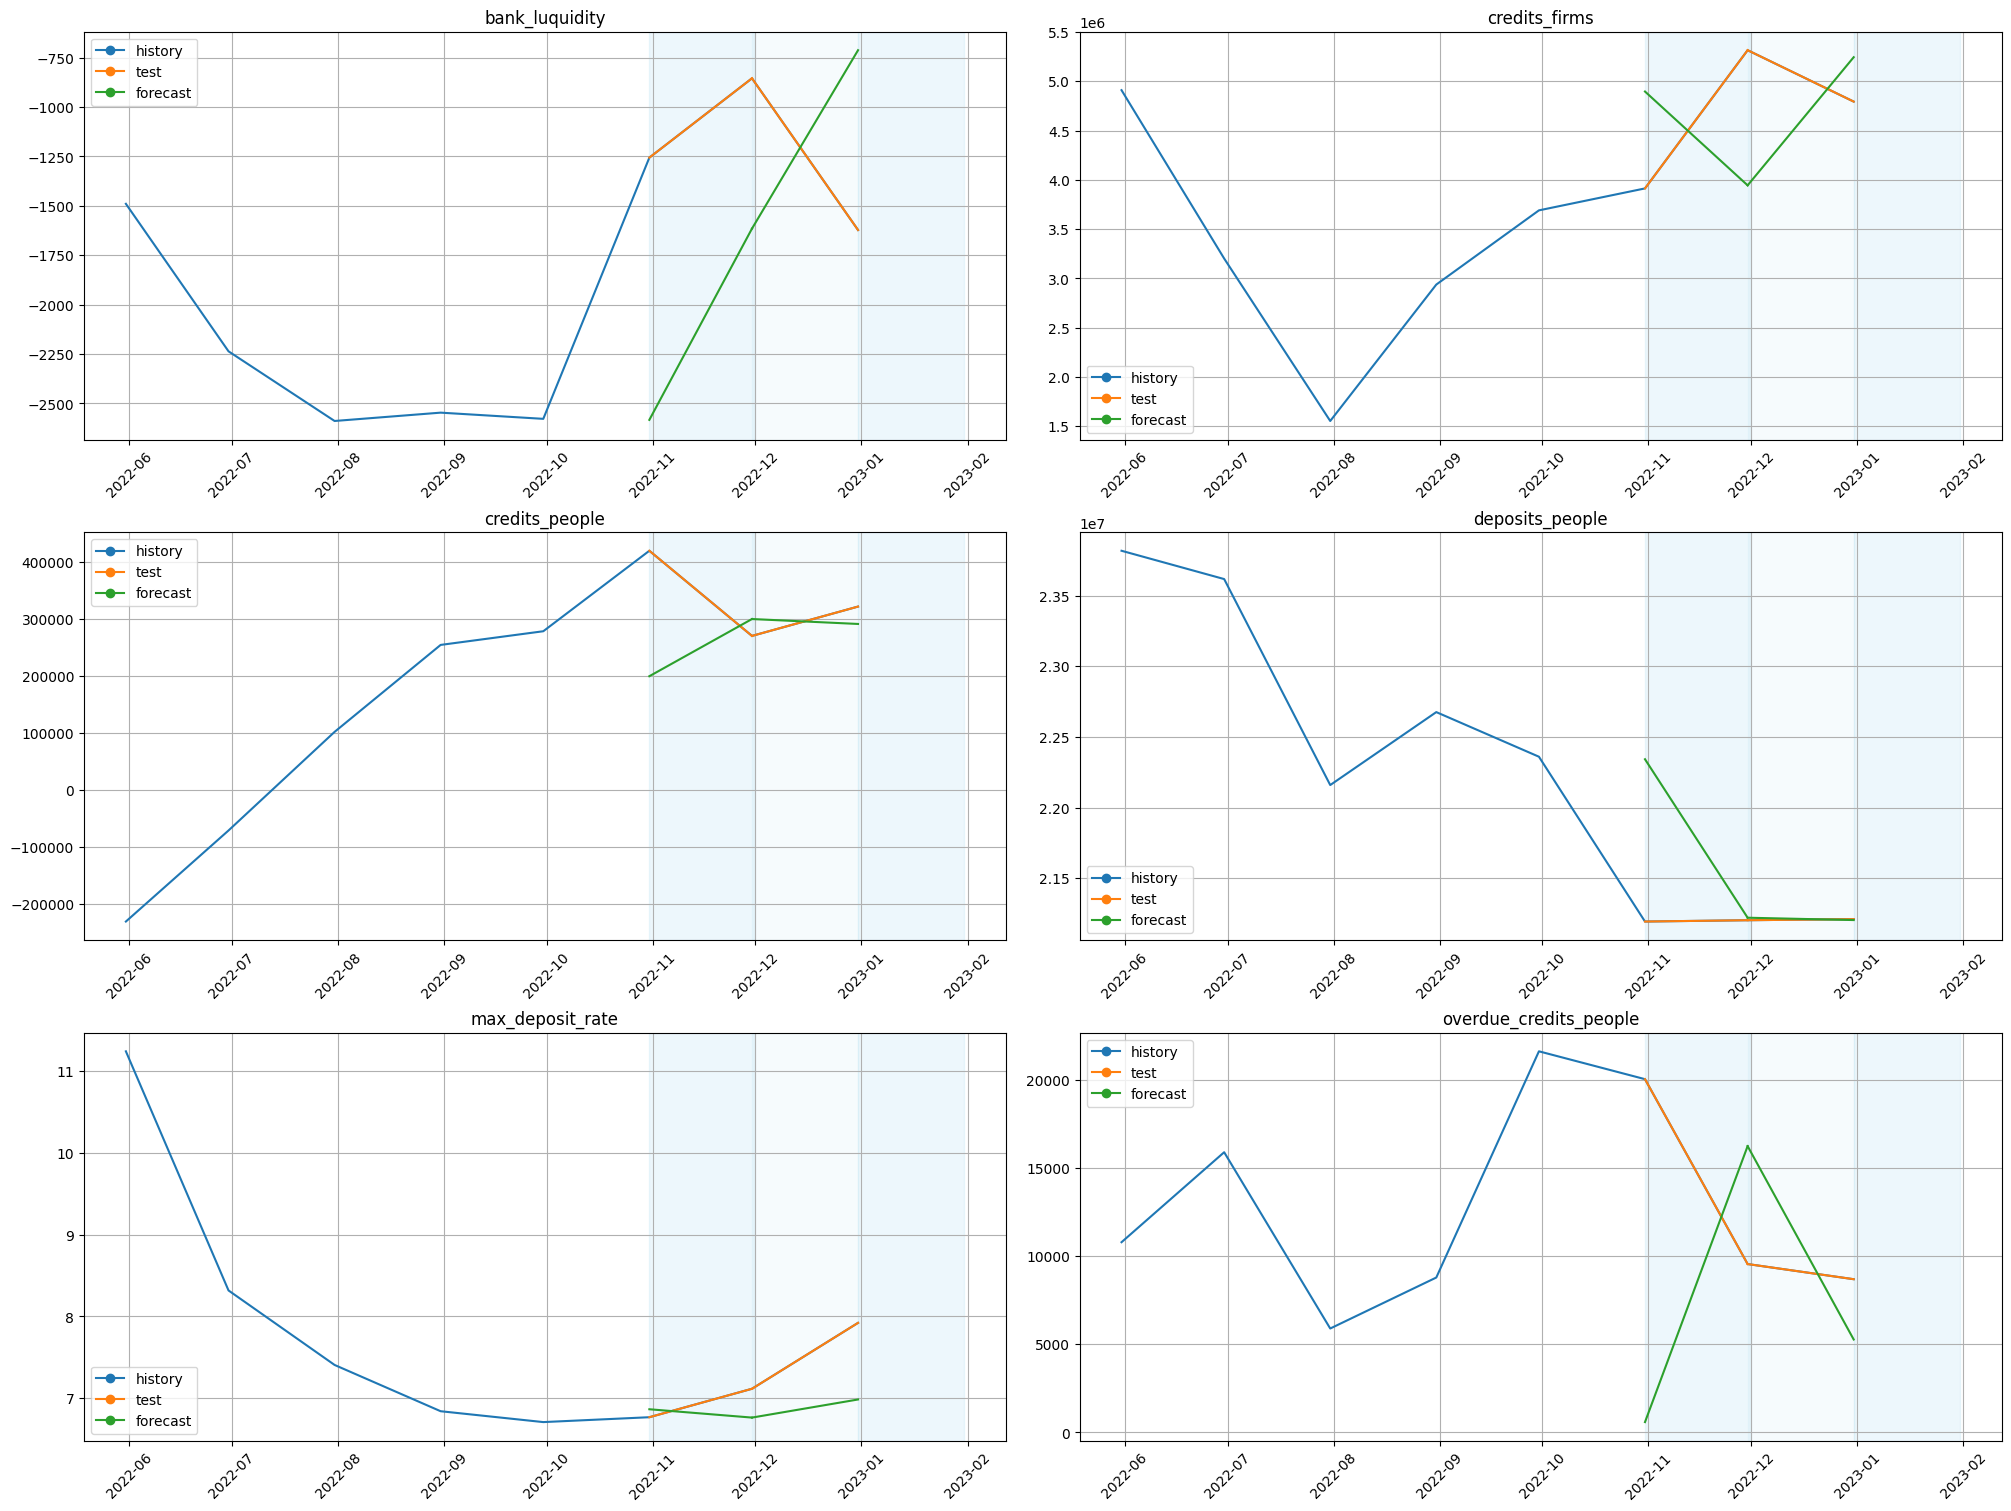

In [281]:
plot_backtest(forecast_cb_ps, tsdataset, history_len=5)


In [282]:
transforms = [
    LagTransform(in_column="target", lags=list(range(1, 3)), out_column="lag"),
]

model = em.CatBoostPerSegmentModel()

pipeline_cb_ps = Pipeline(model=model, transforms=transforms, horizon=1)

metrics_cb_ps, forecast_cb_ps, _ = pipeline_cb_ps.backtest(ts=tsdataset_without_rate, metrics=[MAE(), SMAPE()], n_folds=3)

metrics_cb_ps_df = metrics_cb_ps.groupby('segment').agg({'MAE': 'mean', 'SMAPE':'mean'})
metrics_cb_ps_df

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    5.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    7.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    7.2s finished


,MAE,SMAPE
segment,,
bank_luquidity,1089.053816,81.369761
credits_firms,453153.191403,9.155925
credits_people,139233.143127,45.914961
deposits_people,663936.551359,3.081022
max_deposit_rate,0.477784,6.663343
overdue_credits_people,5602.378620,51.307263


In [283]:
metrics_cb_ps_df.mean()

MAE      210502.466018
SMAPE        32.915379
dtype: float64

### **CatBoostMultiSegmentModel**

In [284]:
model =em.CatBoostMultiSegmentModel()

transforms = [
    LagTransform(in_column="target", lags=list(range(1, 3)), out_column="lag"),
]
pipeline_cb_ms = Pipeline(model=model, transforms=transforms, horizon=1)

metrics_cb_ms, forecast_cb_ms, _ = pipeline_cb_ms.backtest(ts=tsdataset, metrics=[MAE(), SMAPE()], n_folds=3)

metrics_cb_ms_df = metrics_cb_ms.groupby('segment').agg({'MAE': 'mean', 'SMAPE':'mean'})
metrics_cb_ms_df

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    2.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    2.5s finished


,MAE,SMAPE
segment,,
bank_luquidity,6.818133e+04,155.613464
credits_firms,5.674906e+05,12.382412
credits_people,1.225548e+05,44.633800
deposits_people,1.711636e+06,7.591260
max_deposit_rate,4.957832e+04,200.000000
overdue_credits_people,5.324407e+04,185.281204


In [285]:
metrics_cb_ms_df.mean()

MAE      428780.947096
SMAPE       100.917023
dtype: float64

In [286]:
model =em.CatBoostMultiSegmentModel()

pipeline_cb_ms = Pipeline(model=model, transforms=transforms, horizon=1)

metrics_cb_ms, forecast_cb_ms, _ = pipeline_cb_ms.backtest(ts=tsdataset_without_rate, metrics=[MAE(), SMAPE()], n_folds=3)

metrics_cb_ms_df = metrics_cb_ms.groupby('segment').agg({'MAE': 'mean', 'SMAPE':'mean'})
metrics_cb_ms_df

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    2.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    2.4s finished


,MAE,SMAPE
segment,,
bank_luquidity,19112.349414,174.478519
credits_firms,549627.908828,11.695050
credits_people,130351.468757,40.624645
deposits_people,793554.605061,3.665656
max_deposit_rate,10042.172584,198.786913
overdue_credits_people,14897.634222,60.265872


In [287]:
metrics_cb_ms_df.mean()

MAE      252931.023144
SMAPE        81.586109
dtype: float64

###**Exponential Smoothing**

#### HoltModel

In [288]:
model = HoltModel()
transforms = [
    LagTransform(in_column="target", lags=list(range(1, 3)), out_column="lag"),
]

pipeline_holt = Pipeline(model=model, transforms=transforms, horizon=1)

metrics_holt, forecast_holt, _ = pipeline_holt.backtest(ts=tsdataset, metrics=[MAE(), SMAPE()], n_folds=3)

metrics_holt_df = metrics_holt.groupby('segment').agg({'MAE': 'mean', 'SMAPE':'mean'})
metrics_holt_df

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
 

,MAE,SMAPE
segment,,
bank_luquidity,892.471773,58.557874
credits_firms,706862.499905,14.364367
credits_people,111127.125462,33.836197
deposits_people,572279.712294,2.631493
max_deposit_rate,0.429744,5.898858
overdue_credits_people,5134.847054,39.563099


In [289]:
metrics_holt_df.mean()

MAE      232716.181039
SMAPE        25.808648
dtype: float64

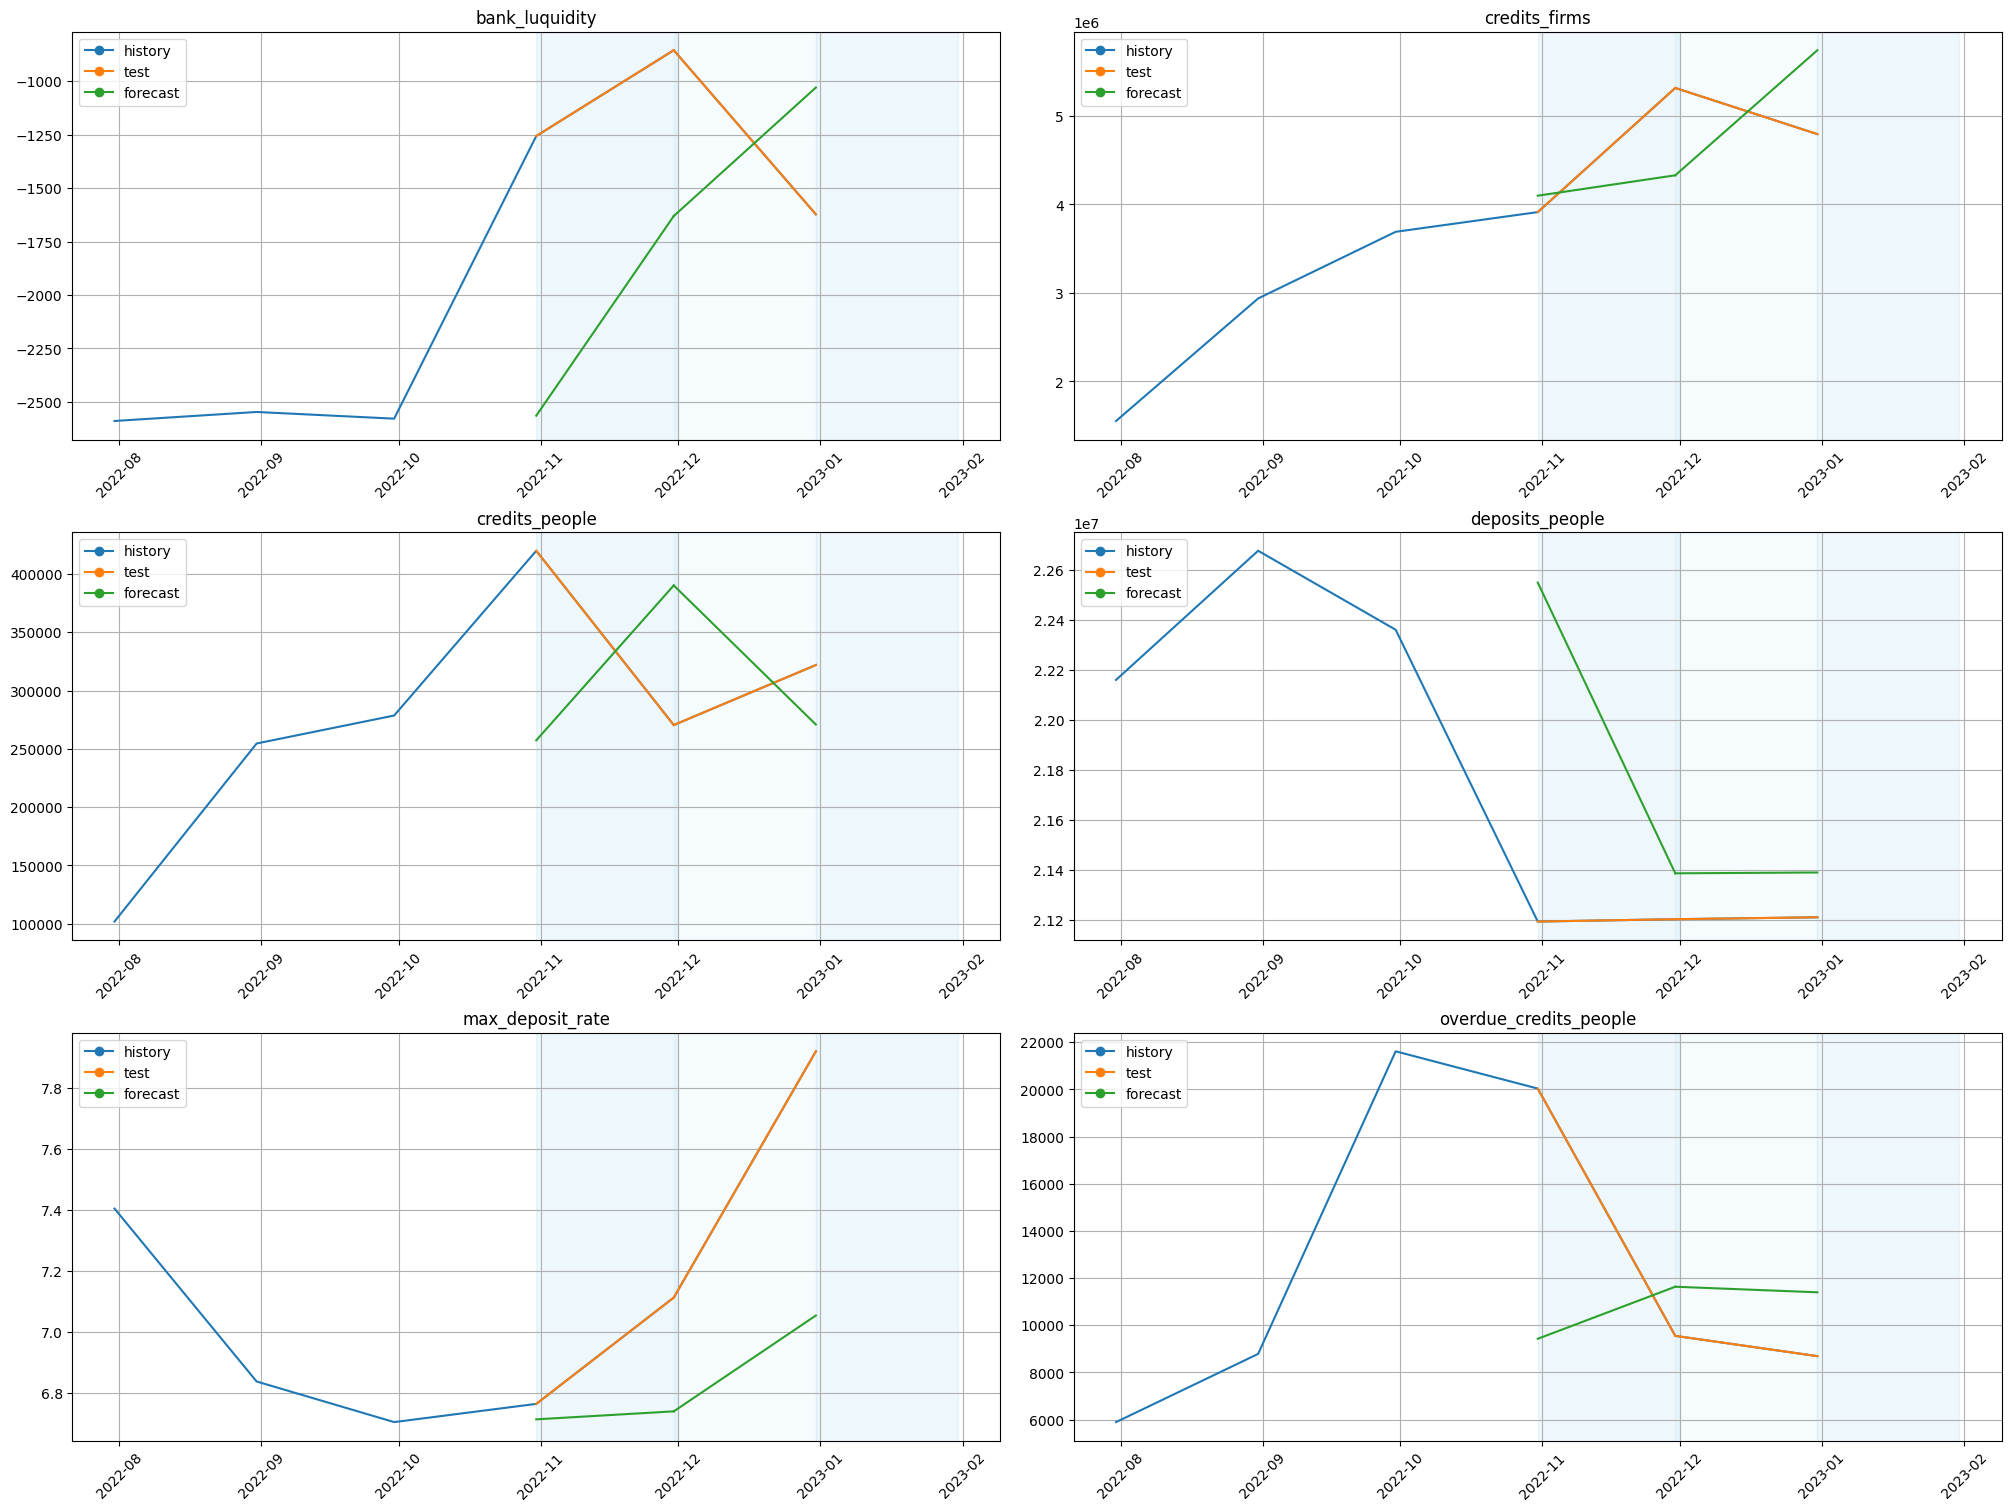

In [290]:
plot_backtest(forecast_holt, tsdataset, history_len=3)


In [291]:
model = HoltModel()
transforms = [
    LagTransform(in_column="target", lags=list(range(1, 3)), out_column="lag"),
]
pipeline_holt = Pipeline(model=model, transforms=transforms, horizon=1)

metrics_holt, forecast_holt, _ = pipeline_holt.backtest(ts=tsdataset_without_rate, metrics=[MAE(), SMAPE()], n_folds=3)

metrics_holt_df = metrics_holt.groupby('segment').agg({'MAE': 'mean', 'SMAPE':'mean'})
metrics_holt_df

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
 

,MAE,SMAPE
segment,,
bank_luquidity,892.471773,58.557874
credits_firms,706862.499905,14.364367
credits_people,111127.125462,33.836197
deposits_people,572279.712294,2.631493
max_deposit_rate,0.429744,5.898858
overdue_credits_people,5134.847054,39.563099


In [292]:
metrics_holt_df.mean()

MAE      232716.181039
SMAPE        25.808648
dtype: float64

#### HoltWintersModel

In [293]:
model = HoltWintersModel()
transforms = [
    LagTransform(in_column="target", lags=list(range(1, 3)), out_column="lag"),
]
pipeline_holt_winter = Pipeline(model=model, transforms=transforms, horizon=1)

metrics_holt_winter, forecast_holt_winter, _ = pipeline_holt_winter.backtest(ts=tsdataset, metrics=[MAE(), SMAPE()], n_folds=3)

metrics_holt_winter_df = metrics_holt_winter.groupby('segment').agg({'MAE': 'mean', 'SMAPE':'mean'})
metrics_holt_winter_df

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
 

,MAE,SMAPE
segment,,
bank_luquidity,887.390717,57.702631
credits_firms,713527.656356,15.528461
credits_people,103856.714625,30.788113
deposits_people,392886.127506,1.804553
max_deposit_rate,0.411588,5.632347
overdue_credits_people,4685.219123,36.274672


In [294]:
metrics_holt_winter_df.mean()

MAE      202640.586652
SMAPE        24.621796
dtype: float64

In [295]:
model = HoltWintersModel()
transforms = [
    LagTransform(in_column="target", lags=list(range(1, 3)), out_column="lag"),
]
pipeline_holt_winter = Pipeline(model=model, transforms=transforms, horizon=1)

metrics_holt_winter, forecast_holt_winter, _ = pipeline_holt_winter.backtest(ts=tsdataset_without_rate, metrics=[MAE(), SMAPE()], n_folds=3)

metrics_holt_winter_df = metrics_holt_winter.groupby('segment').agg({'MAE': 'mean', 'SMAPE':'mean'})
metrics_holt_winter_df

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
 

,MAE,SMAPE
segment,,
bank_luquidity,887.390717,57.702631
credits_firms,713527.656356,15.528461
credits_people,103856.714625,30.788113
deposits_people,392886.127506,1.804553
max_deposit_rate,0.411588,5.632347
overdue_credits_people,4685.219123,36.274672


In [296]:
metrics_holt_winter_df.mean()

MAE      202640.586652
SMAPE        24.621796
dtype: float64